In [2]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Keras version 2.0.4
Tensorflow version 1.1.0


In [3]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [4]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\BallTracking\Training\'
'.\..\..\Data\Processed\BallTracking\Training\balltracking_0.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_1.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_10.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_11.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_12.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_13.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_14.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_15.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_16.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_17.avi': 10000 frames found.
'.\..\..\Data\Proces

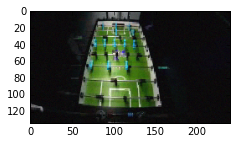

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


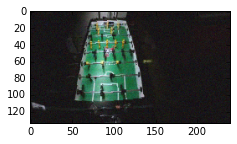

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


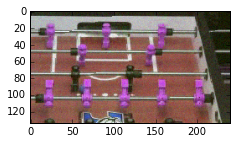

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


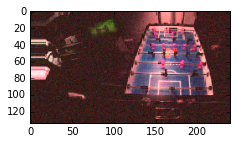

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


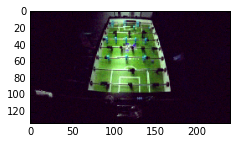

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


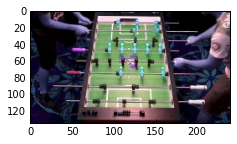

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


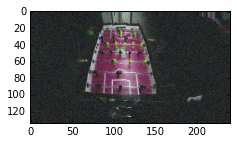

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


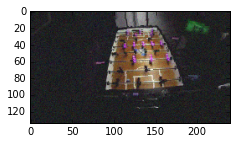

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


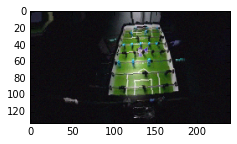

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


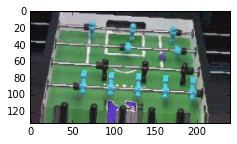

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


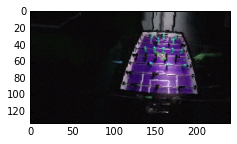

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


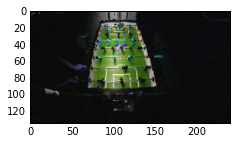

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


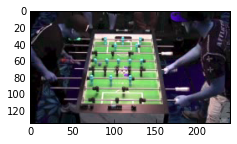

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


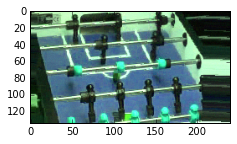

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


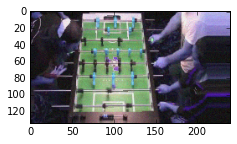

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


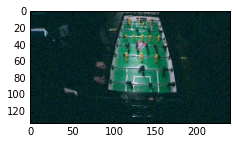

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


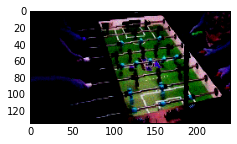

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


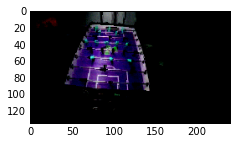

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


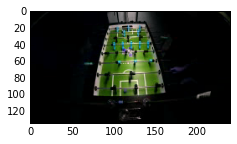

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


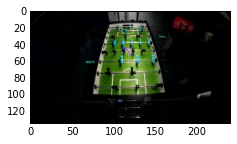

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [5]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [6]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [7]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [25]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))


# Create the embedding module
frame_in = Input(shape=(image_height, image_width, image_channels,))
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(frame_in)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res0 = x

x = MaxPooling2D((1, 2))(x)

x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res1 = x

x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res2 = x
x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res3 = x
x = MaxPooling2D((2, 2))(x)



x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
x = Conv2D(cnn_kernel_count, (3, 3),
           padding = "same",
           activation = "relu",)(x)
res4 = x
embedding = MaxPooling2D((2, 2))(x)


foosball_embedding = Model(frame_in, [embedding, res0, res1, res2, res3, res4])
foosball_embedding.summary()

# Transfer the weights from the foosball embedding
foosball_embedding.load_weights("foosball_embedding.hdf")

# Build our new model that uses this transferred model
frame = Input(shape=(image_height, image_width, image_channels,))
[embedding, res0, res1, res2, res3, res4] = foosball_embedding(frame)

# Add a fully connected layer
x = Flatten()(embedding)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=frame, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 134, 120, 40)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 134, 120, 40)      14440     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (N

Batch size 30: 87 training batches, 25 validation batches
Epoch 1/1
88/87 [==============================] - 74s - loss: 2.0650 - categorical_accuracy: 0.2451 - val_loss: 1.9128 - val_categorical_accuracy: 0.2449


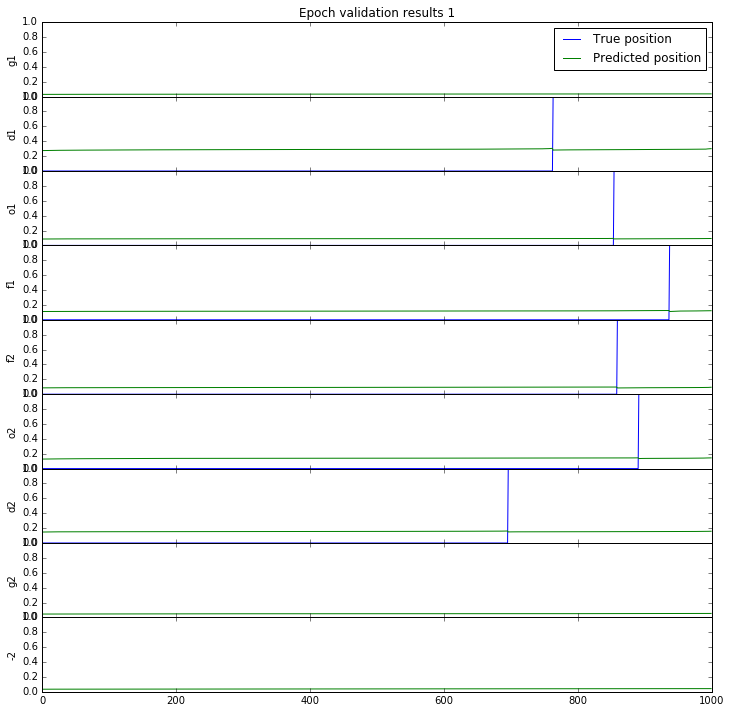

Wrote model to .\ModelsTransfer\weights_1.hdf
Epoch 2/2
88/87 [==============================] - 65s - loss: 1.9312 - categorical_accuracy: 0.2432 - val_loss: 1.8473 - val_categorical_accuracy: 0.2218
Wrote model to .\ModelsTransfer\weights_2.hdf
Epoch 3/3
88/87 [==============================] - 67s - loss: 1.9041 - categorical_accuracy: 0.2292 - val_loss: 1.7997 - val_categorical_accuracy: 0.2487
Wrote model to .\ModelsTransfer\weights_3.hdf
Epoch 4/4
88/87 [==============================] - 66s - loss: 1.8777 - categorical_accuracy: 0.2405 - val_loss: 1.8179 - val_categorical_accuracy: 0.2372
Wrote model to .\ModelsTransfer\weights_4.hdf
Epoch 5/5
88/87 [==============================] - 62s - loss: 1.8668 - categorical_accuracy: 0.2413 - val_loss: 1.8234 - val_categorical_accuracy: 0.2308
Wrote model to .\ModelsTransfer\weights_5.hdf
Epoch 6/6
88/87 [==============================] - 64s - loss: 1.8540 - categorical_accuracy: 0.2379 - val_loss: 1.8193 - val_categorical_accuracy: 0.

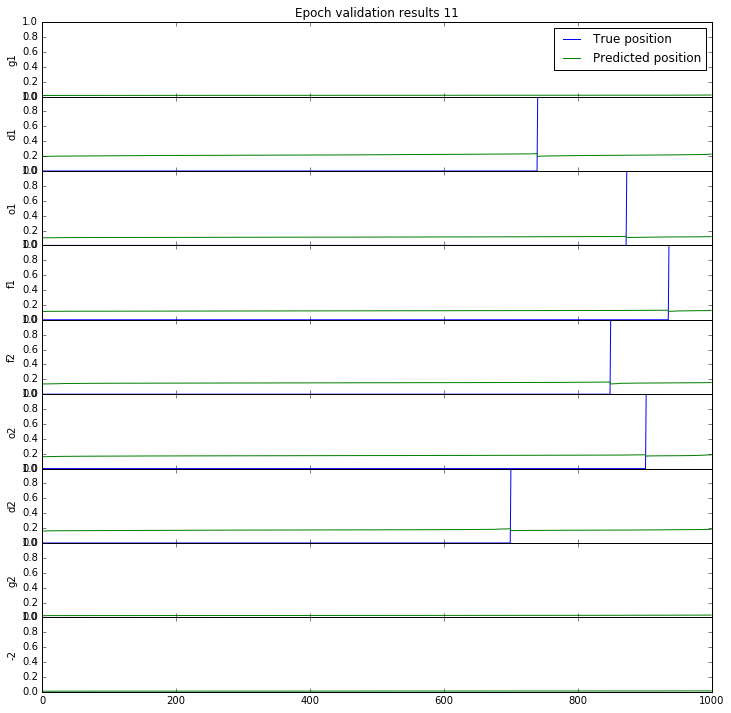

Wrote model to .\ModelsTransfer\weights_11.hdf
Epoch 12/12
88/87 [==============================] - 76s - loss: 1.8368 - categorical_accuracy: 0.2557 - val_loss: 1.8108 - val_categorical_accuracy: 0.2103
Wrote model to .\ModelsTransfer\weights_12.hdf
Epoch 13/13
88/87 [==============================] - 75s - loss: 1.8400 - categorical_accuracy: 0.2629 - val_loss: 1.8160 - val_categorical_accuracy: 0.2321
Wrote model to .\ModelsTransfer\weights_13.hdf
Epoch 14/14
88/87 [==============================] - 74s - loss: 1.8483 - categorical_accuracy: 0.2587 - val_loss: 1.8362 - val_categorical_accuracy: 0.1321
Wrote model to .\ModelsTransfer\weights_14.hdf
Epoch 15/15
88/87 [==============================] - 76s - loss: 1.8128 - categorical_accuracy: 0.2712 - val_loss: 1.8114 - val_categorical_accuracy: 0.1590
Wrote model to .\ModelsTransfer\weights_15.hdf
Epoch 16/16
88/87 [==============================] - 75s - loss: 1.8435 - categorical_accuracy: 0.2580 - val_loss: 1.8313 - val_categoric

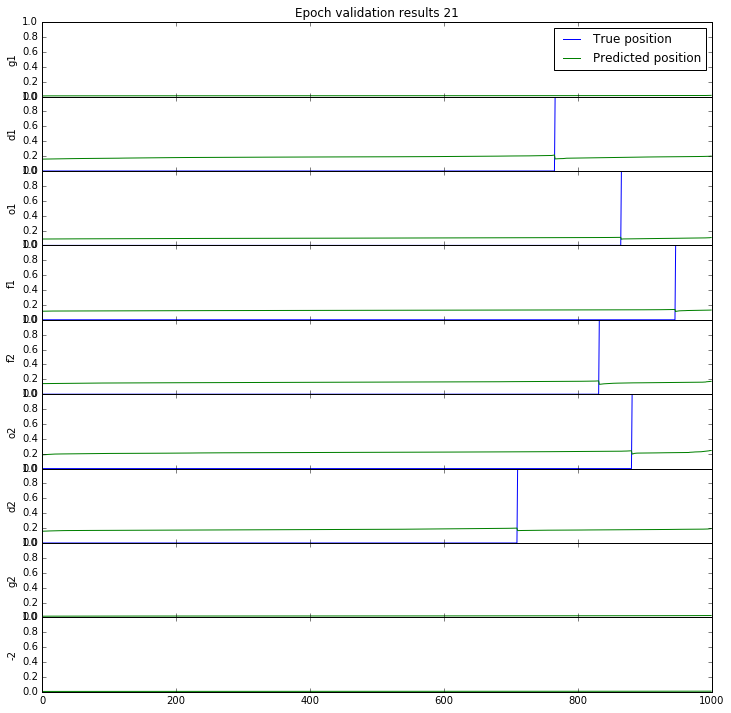

Wrote model to .\ModelsTransfer\weights_21.hdf
Epoch 22/22
88/87 [==============================] - 76s - loss: 1.8037 - categorical_accuracy: 0.2598 - val_loss: 1.8602 - val_categorical_accuracy: 0.0962
Wrote model to .\ModelsTransfer\weights_22.hdf
Epoch 23/23
88/87 [==============================] - 75s - loss: 1.8151 - categorical_accuracy: 0.2625 - val_loss: 1.8210 - val_categorical_accuracy: 0.1423
Wrote model to .\ModelsTransfer\weights_23.hdf
Epoch 24/24
88/87 [==============================] - 73s - loss: 1.7848 - categorical_accuracy: 0.2845 - val_loss: 1.8046 - val_categorical_accuracy: 0.2282
Wrote model to .\ModelsTransfer\weights_24.hdf
Epoch 25/25
88/87 [==============================] - 75s - loss: 1.7660 - categorical_accuracy: 0.3019 - val_loss: 1.8549 - val_categorical_accuracy: 0.1038
Wrote model to .\ModelsTransfer\weights_25.hdf
Epoch 26/26
88/87 [==============================] - 75s - loss: 1.7772 - categorical_accuracy: 0.2989 - val_loss: 1.8524 - val_categoric

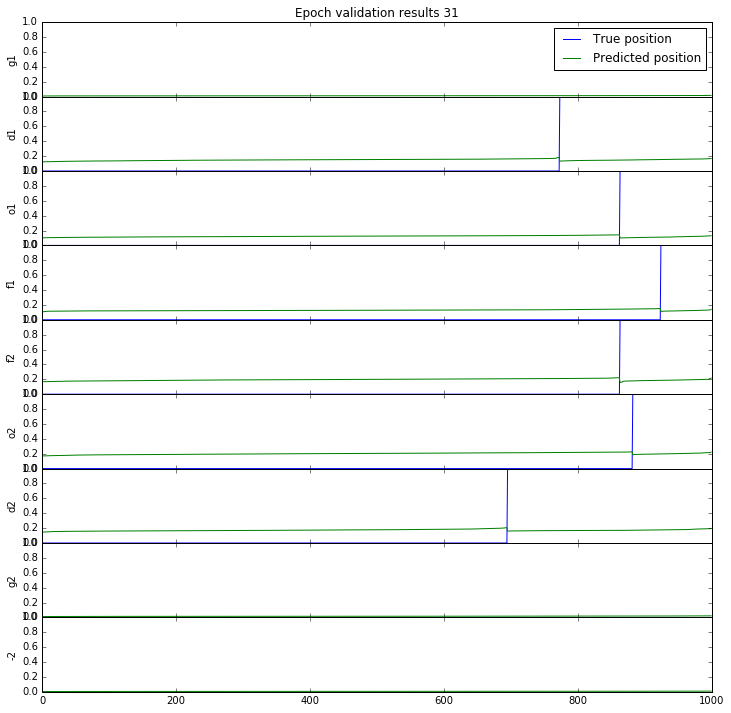

Wrote model to .\ModelsTransfer\weights_31.hdf
Epoch 32/32
88/87 [==============================] - 76s - loss: 1.7563 - categorical_accuracy: 0.2883 - val_loss: 1.8273 - val_categorical_accuracy: 0.2103
Wrote model to .\ModelsTransfer\weights_32.hdf
Epoch 33/33
88/87 [==============================] - 76s - loss: 1.7400 - categorical_accuracy: 0.3129 - val_loss: 1.8294 - val_categorical_accuracy: 0.1769
Wrote model to .\ModelsTransfer\weights_33.hdf
Epoch 34/34
88/87 [==============================] - 74s - loss: 1.7231 - categorical_accuracy: 0.3106 - val_loss: 1.8525 - val_categorical_accuracy: 0.1000
Wrote model to .\ModelsTransfer\weights_34.hdf
Epoch 35/35
88/87 [==============================] - 75s - loss: 1.7225 - categorical_accuracy: 0.3170 - val_loss: 1.8146 - val_categorical_accuracy: 0.2013
Wrote model to .\ModelsTransfer\weights_35.hdf
Epoch 36/36
88/87 [==============================] - 76s - loss: 1.7105 - categorical_accuracy: 0.3205 - val_loss: 1.8527 - val_categoric

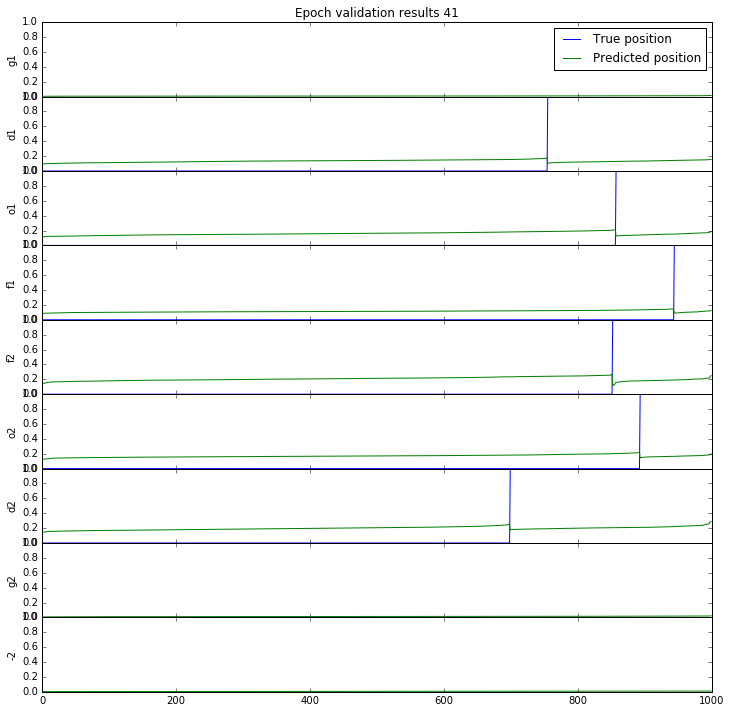

Wrote model to .\ModelsTransfer\weights_41.hdf
Epoch 42/42
88/87 [==============================] - 76s - loss: 1.6784 - categorical_accuracy: 0.3420 - val_loss: 1.8111 - val_categorical_accuracy: 0.2667
Wrote model to .\ModelsTransfer\weights_42.hdf
Epoch 43/43
88/87 [==============================] - 75s - loss: 1.6643 - categorical_accuracy: 0.3458 - val_loss: 1.8150 - val_categorical_accuracy: 0.2487
Wrote model to .\ModelsTransfer\weights_43.hdf
Epoch 44/44
88/87 [==============================] - 77s - loss: 1.6605 - categorical_accuracy: 0.3413 - val_loss: 1.7916 - val_categorical_accuracy: 0.2910
Wrote model to .\ModelsTransfer\weights_44.hdf
Epoch 45/45
88/87 [==============================] - 74s - loss: 1.6438 - categorical_accuracy: 0.3519 - val_loss: 1.8252 - val_categorical_accuracy: 0.2718
Wrote model to .\ModelsTransfer\weights_45.hdf
Epoch 46/46
88/87 [==============================] - 76s - loss: 1.6427 - categorical_accuracy: 0.3614 - val_loss: 1.8221 - val_categoric

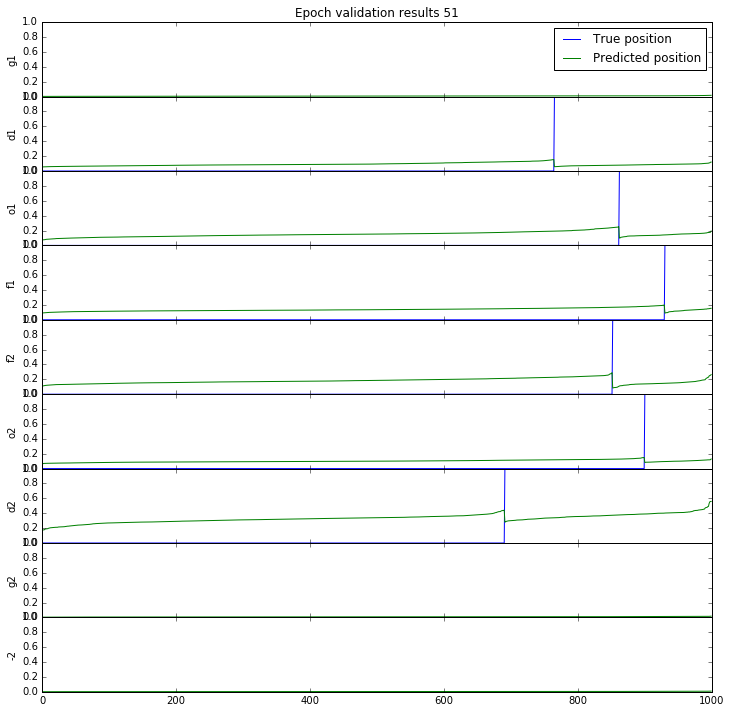

Wrote model to .\ModelsTransfer\weights_51.hdf
Epoch 52/52
88/87 [==============================] - 75s - loss: 1.5649 - categorical_accuracy: 0.3966 - val_loss: 1.8158 - val_categorical_accuracy: 0.2949
Wrote model to .\ModelsTransfer\weights_52.hdf
Epoch 53/53
88/87 [==============================] - 76s - loss: 1.5869 - categorical_accuracy: 0.3746 - val_loss: 1.8216 - val_categorical_accuracy: 0.3154
Wrote model to .\ModelsTransfer\weights_53.hdf
Epoch 54/54
88/87 [==============================] - 74s - loss: 1.5952 - categorical_accuracy: 0.3708 - val_loss: 1.8105 - val_categorical_accuracy: 0.2974
Wrote model to .\ModelsTransfer\weights_54.hdf
Epoch 55/55
88/87 [==============================] - 75s - loss: 1.5800 - categorical_accuracy: 0.3845 - val_loss: 1.8052 - val_categorical_accuracy: 0.2987
Wrote model to .\ModelsTransfer\weights_55.hdf
Epoch 56/56
88/87 [==============================] - 75s - loss: 1.5812 - categorical_accuracy: 0.3886 - val_loss: 1.7816 - val_categoric

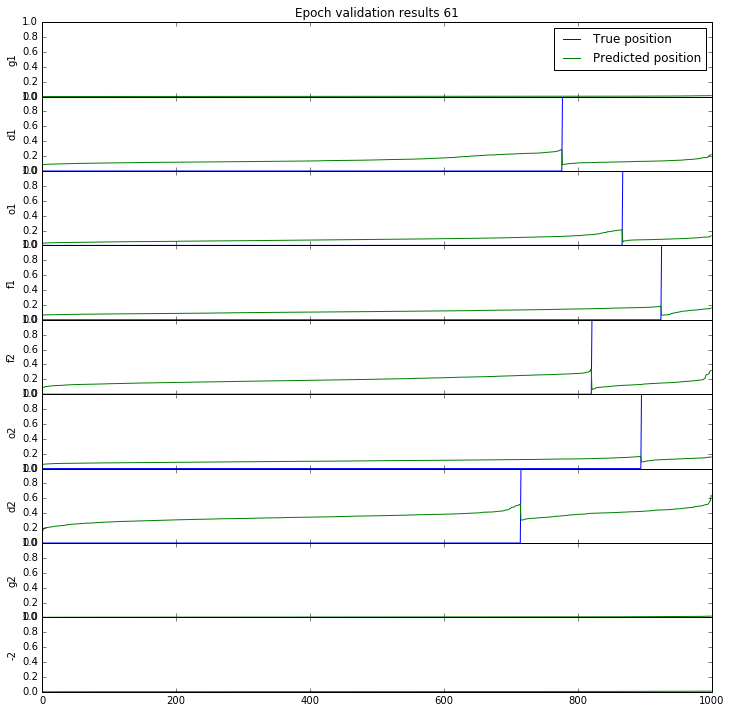

Wrote model to .\ModelsTransfer\weights_61.hdf
Epoch 62/62
88/87 [==============================] - 75s - loss: 1.5553 - categorical_accuracy: 0.3913 - val_loss: 1.7468 - val_categorical_accuracy: 0.2923
Wrote model to .\ModelsTransfer\weights_62.hdf
Epoch 63/63
88/87 [==============================] - 75s - loss: 1.5102 - categorical_accuracy: 0.4095 - val_loss: 1.7621 - val_categorical_accuracy: 0.2731
Wrote model to .\ModelsTransfer\weights_63.hdf
Epoch 64/64
88/87 [==============================] - 75s - loss: 1.5219 - categorical_accuracy: 0.4049 - val_loss: 1.7605 - val_categorical_accuracy: 0.2808
Wrote model to .\ModelsTransfer\weights_64.hdf
Epoch 65/65
88/87 [==============================] - 75s - loss: 1.5092 - categorical_accuracy: 0.4023 - val_loss: 1.7539 - val_categorical_accuracy: 0.2641
Wrote model to .\ModelsTransfer\weights_65.hdf
Epoch 66/66
88/87 [==============================] - 75s - loss: 1.5059 - categorical_accuracy: 0.4227 - val_loss: 1.7295 - val_categoric

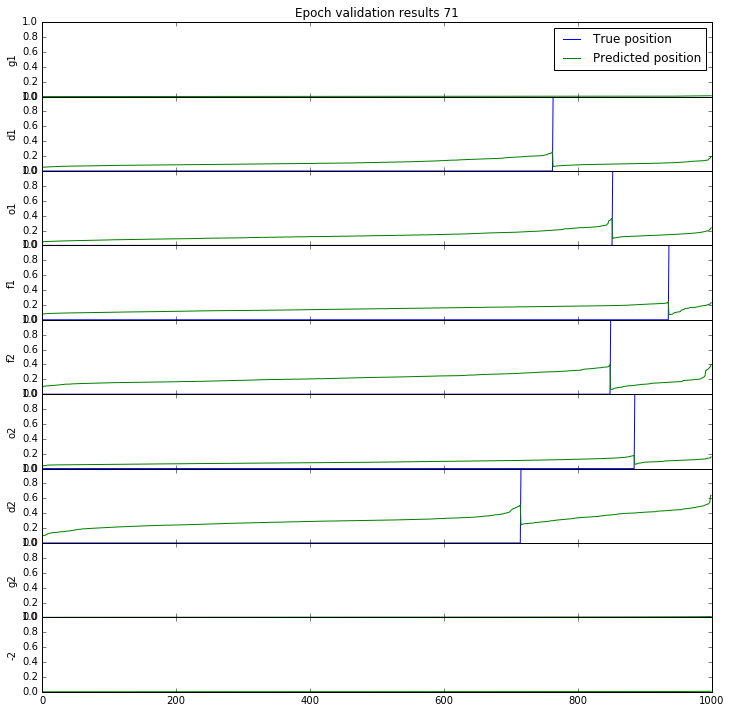

Wrote model to .\ModelsTransfer\weights_71.hdf
Epoch 72/72
88/87 [==============================] - 73s - loss: 1.4845 - categorical_accuracy: 0.4201 - val_loss: 1.7573 - val_categorical_accuracy: 0.2641
Wrote model to .\ModelsTransfer\weights_72.hdf
Epoch 73/73
88/87 [==============================] - 74s - loss: 1.4633 - categorical_accuracy: 0.4280 - val_loss: 1.7271 - val_categorical_accuracy: 0.2692
Wrote model to .\ModelsTransfer\weights_73.hdf
Epoch 74/74
88/87 [==============================] - 75s - loss: 1.4510 - categorical_accuracy: 0.4311 - val_loss: 1.7612 - val_categorical_accuracy: 0.3077
Wrote model to .\ModelsTransfer\weights_74.hdf
Epoch 75/75
88/87 [==============================] - 75s - loss: 1.4546 - categorical_accuracy: 0.4345 - val_loss: 1.7364 - val_categorical_accuracy: 0.2769
Wrote model to .\ModelsTransfer\weights_75.hdf
Epoch 76/76
88/87 [==============================] - 76s - loss: 1.4501 - categorical_accuracy: 0.4367 - val_loss: 1.7099 - val_categoric

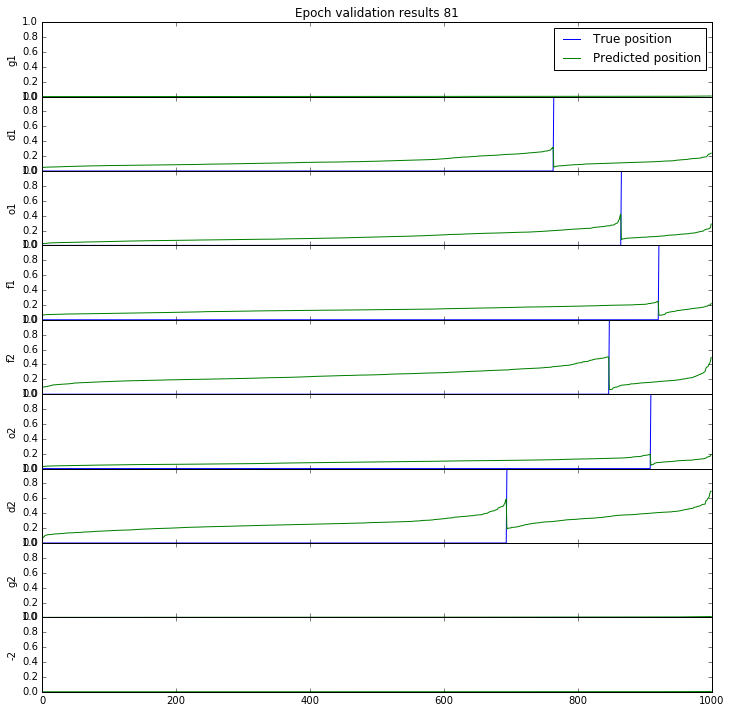

Wrote model to .\ModelsTransfer\weights_81.hdf
Epoch 82/82
88/87 [==============================] - 74s - loss: 1.4423 - categorical_accuracy: 0.4455 - val_loss: 1.7003 - val_categorical_accuracy: 0.2769
Wrote model to .\ModelsTransfer\weights_82.hdf
Epoch 83/83
88/87 [==============================] - 74s - loss: 1.4198 - categorical_accuracy: 0.4621 - val_loss: 1.7279 - val_categorical_accuracy: 0.2628
Wrote model to .\ModelsTransfer\weights_83.hdf
Epoch 84/84
88/87 [==============================] - 75s - loss: 1.3935 - categorical_accuracy: 0.4750 - val_loss: 1.7509 - val_categorical_accuracy: 0.2667
Wrote model to .\ModelsTransfer\weights_84.hdf
Epoch 85/85
88/87 [==============================] - 76s - loss: 1.3880 - categorical_accuracy: 0.4625 - val_loss: 1.7069 - val_categorical_accuracy: 0.2551
Wrote model to .\ModelsTransfer\weights_85.hdf
Epoch 86/86
88/87 [==============================] - 74s - loss: 1.3684 - categorical_accuracy: 0.4761 - val_loss: 1.7564 - val_categoric

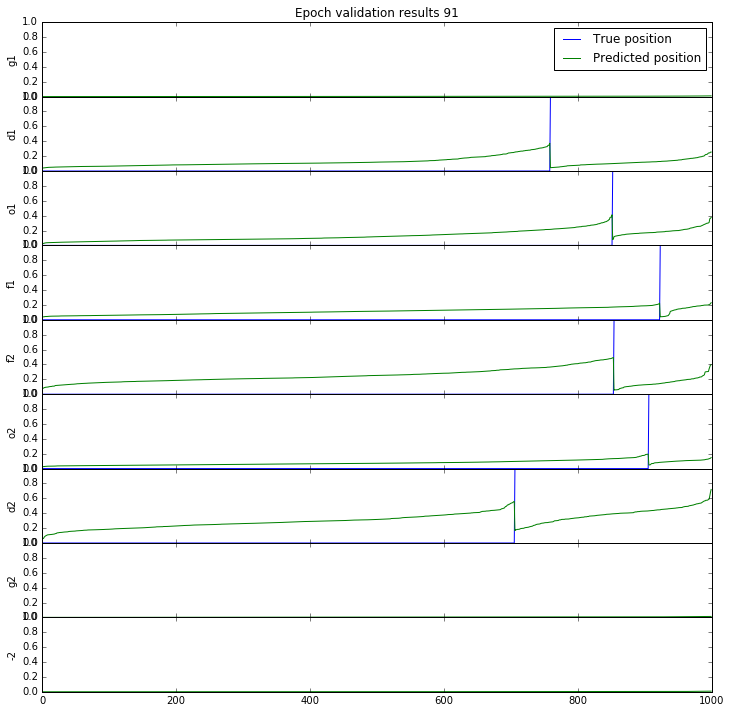

Wrote model to .\ModelsTransfer\weights_91.hdf
Epoch 92/92
88/87 [==============================] - 76s - loss: 1.3661 - categorical_accuracy: 0.4727 - val_loss: 1.7187 - val_categorical_accuracy: 0.2333
Wrote model to .\ModelsTransfer\weights_92.hdf
Epoch 93/93
88/87 [==============================] - 76s - loss: 1.3453 - categorical_accuracy: 0.4799 - val_loss: 1.6978 - val_categorical_accuracy: 0.2654
Wrote model to .\ModelsTransfer\weights_93.hdf
Epoch 94/94
88/87 [==============================] - 77s - loss: 1.3554 - categorical_accuracy: 0.4617 - val_loss: 1.6623 - val_categorical_accuracy: 0.3218
Wrote model to .\ModelsTransfer\weights_94.hdf
Epoch 95/95
88/87 [==============================] - 74s - loss: 1.3552 - categorical_accuracy: 0.4902 - val_loss: 1.6763 - val_categorical_accuracy: 0.2756
Wrote model to .\ModelsTransfer\weights_95.hdf
Epoch 96/96
88/87 [==============================] - 76s - loss: 1.3582 - categorical_accuracy: 0.4780 - val_loss: 1.6972 - val_categoric

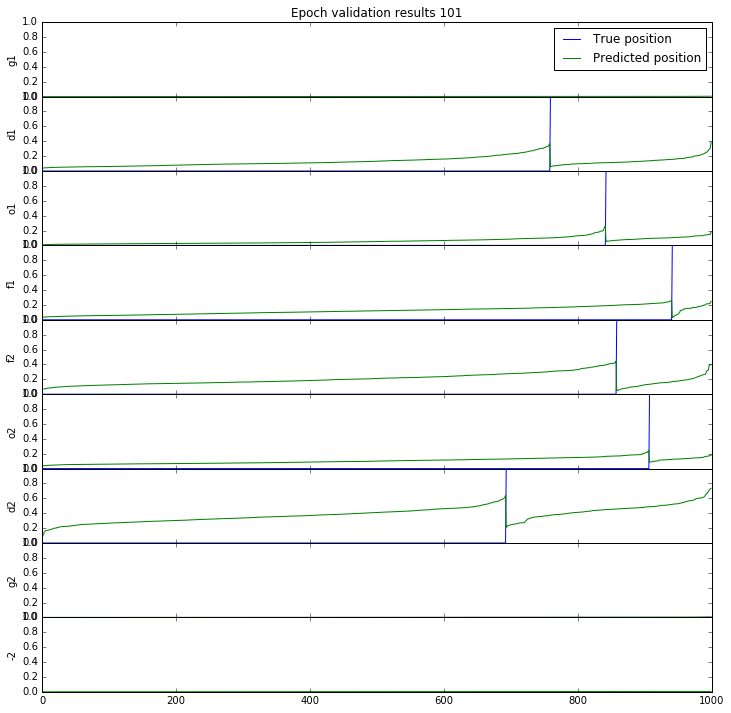

Wrote model to .\ModelsTransfer\weights_101.hdf
Epoch 102/102
88/87 [==============================] - 76s - loss: 1.3166 - categorical_accuracy: 0.5011 - val_loss: 1.6906 - val_categorical_accuracy: 0.2692
Wrote model to .\ModelsTransfer\weights_102.hdf
Epoch 103/103
88/87 [==============================] - 74s - loss: 1.3357 - categorical_accuracy: 0.4875 - val_loss: 1.6371 - val_categorical_accuracy: 0.3205
Wrote model to .\ModelsTransfer\weights_103.hdf
Epoch 104/104
88/87 [==============================] - 74s - loss: 1.3269 - categorical_accuracy: 0.4909 - val_loss: 1.6670 - val_categorical_accuracy: 0.2538
Wrote model to .\ModelsTransfer\weights_104.hdf
Epoch 105/105
88/87 [==============================] - 75s - loss: 1.3184 - categorical_accuracy: 0.4920 - val_loss: 1.6959 - val_categorical_accuracy: 0.2962
Wrote model to .\ModelsTransfer\weights_105.hdf
Epoch 106/106
88/87 [==============================] - 74s - loss: 1.3355 - categorical_accuracy: 0.4837 - val_loss: 1.6579 

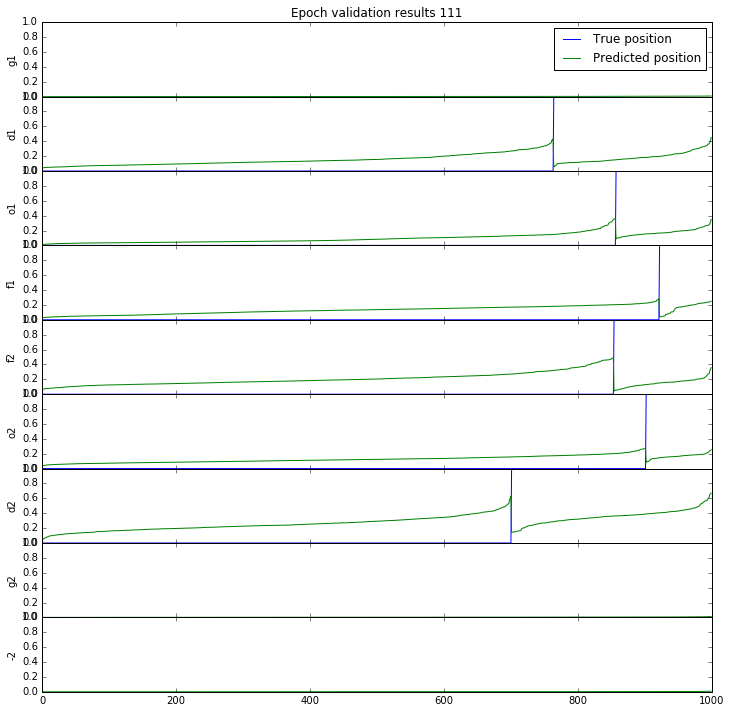

Wrote model to .\ModelsTransfer\weights_111.hdf
Epoch 112/112
88/87 [==============================] - 75s - loss: 1.2861 - categorical_accuracy: 0.5125 - val_loss: 1.6028 - val_categorical_accuracy: 0.2846
Wrote model to .\ModelsTransfer\weights_112.hdf
Epoch 113/113
88/87 [==============================] - 74s - loss: 1.2995 - categorical_accuracy: 0.5140 - val_loss: 1.6354 - val_categorical_accuracy: 0.2756
Wrote model to .\ModelsTransfer\weights_113.hdf
Epoch 114/114
88/87 [==============================] - 78s - loss: 1.2776 - categorical_accuracy: 0.5038 - val_loss: 1.5904 - val_categorical_accuracy: 0.2962
Wrote model to .\ModelsTransfer\weights_114.hdf
Epoch 115/115
88/87 [==============================] - 75s - loss: 1.2561 - categorical_accuracy: 0.5295 - val_loss: 1.6158 - val_categorical_accuracy: 0.2923
Wrote model to .\ModelsTransfer\weights_115.hdf
Epoch 116/116
88/87 [==============================] - 74s - loss: 1.2850 - categorical_accuracy: 0.5091 - val_loss: 1.6639 

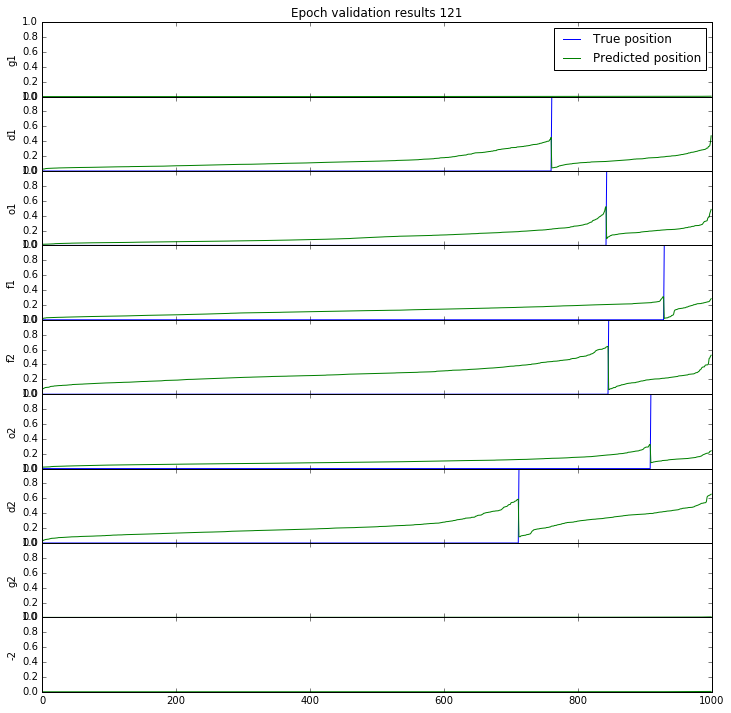

Wrote model to .\ModelsTransfer\weights_121.hdf
Epoch 122/122
88/87 [==============================] - 74s - loss: 1.2601 - categorical_accuracy: 0.5117 - val_loss: 1.6542 - val_categorical_accuracy: 0.2949
Wrote model to .\ModelsTransfer\weights_122.hdf
Epoch 123/123
88/87 [==============================] - 74s - loss: 1.2314 - categorical_accuracy: 0.5186 - val_loss: 1.5825 - val_categorical_accuracy: 0.2756
Wrote model to .\ModelsTransfer\weights_123.hdf
Epoch 124/124
88/87 [==============================] - 75s - loss: 1.2413 - categorical_accuracy: 0.5466 - val_loss: 1.6161 - val_categorical_accuracy: 0.2256
Wrote model to .\ModelsTransfer\weights_124.hdf
Epoch 125/125
88/87 [==============================] - 75s - loss: 1.2153 - categorical_accuracy: 0.5303 - val_loss: 1.5753 - val_categorical_accuracy: 0.3654
Wrote model to .\ModelsTransfer\weights_125.hdf
Epoch 126/126
88/87 [==============================] - 74s - loss: 1.2307 - categorical_accuracy: 0.5311 - val_loss: 1.5859 

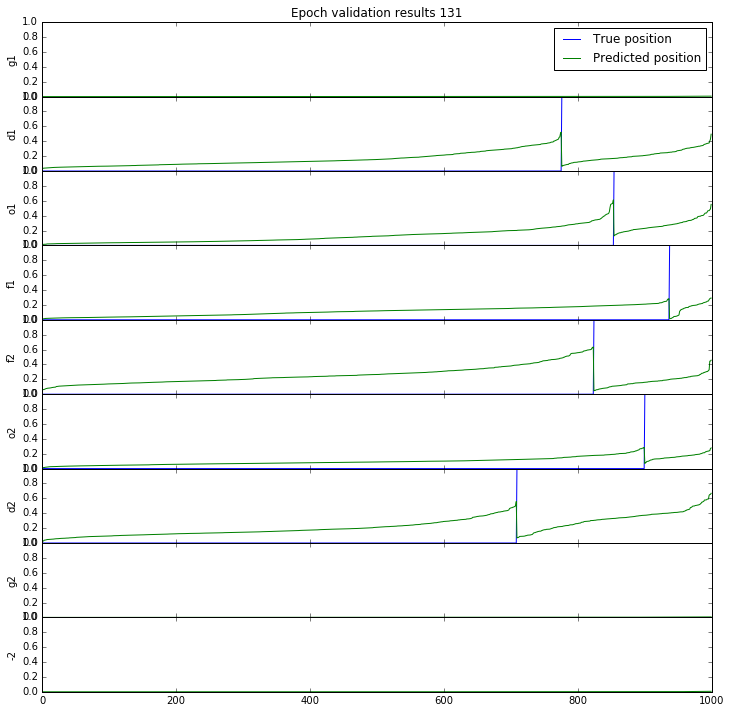

Wrote model to .\ModelsTransfer\weights_131.hdf
Epoch 132/132
88/87 [==============================] - 76s - loss: 1.2157 - categorical_accuracy: 0.5428 - val_loss: 1.5531 - val_categorical_accuracy: 0.3885
Wrote model to .\ModelsTransfer\weights_132.hdf
Epoch 133/133
88/87 [==============================] - 74s - loss: 1.2216 - categorical_accuracy: 0.5477 - val_loss: 1.5699 - val_categorical_accuracy: 0.3359
Wrote model to .\ModelsTransfer\weights_133.hdf
Epoch 134/134
88/87 [==============================] - 75s - loss: 1.2261 - categorical_accuracy: 0.5273 - val_loss: 1.5927 - val_categorical_accuracy: 0.3577
Wrote model to .\ModelsTransfer\weights_134.hdf
Epoch 135/135
88/87 [==============================] - 74s - loss: 1.2150 - categorical_accuracy: 0.5394 - val_loss: 1.5039 - val_categorical_accuracy: 0.3859
Wrote model to .\ModelsTransfer\weights_135.hdf
Epoch 136/136
88/87 [==============================] - 74s - loss: 1.2058 - categorical_accuracy: 0.5337 - val_loss: 1.4836 

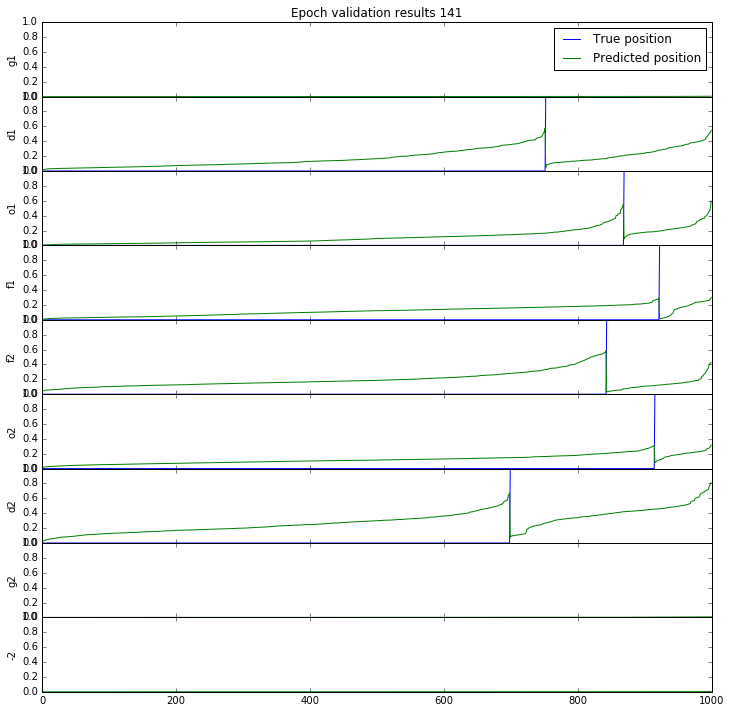

Wrote model to .\ModelsTransfer\weights_141.hdf
Epoch 142/142
88/87 [==============================] - 76s - loss: 1.1939 - categorical_accuracy: 0.5462 - val_loss: 1.4586 - val_categorical_accuracy: 0.4859
Wrote model to .\ModelsTransfer\weights_142.hdf
Epoch 143/143
88/87 [==============================] - 76s - loss: 1.2009 - categorical_accuracy: 0.5462 - val_loss: 1.5207 - val_categorical_accuracy: 0.3769
Wrote model to .\ModelsTransfer\weights_143.hdf
Epoch 144/144
88/87 [==============================] - 76s - loss: 1.2206 - categorical_accuracy: 0.5420 - val_loss: 1.4638 - val_categorical_accuracy: 0.4141
Wrote model to .\ModelsTransfer\weights_144.hdf
Epoch 145/145
88/87 [==============================] - 74s - loss: 1.1993 - categorical_accuracy: 0.5451 - val_loss: 1.4878 - val_categorical_accuracy: 0.3846
Wrote model to .\ModelsTransfer\weights_145.hdf
Epoch 146/146
88/87 [==============================] - 76s - loss: 1.1985 - categorical_accuracy: 0.5371 - val_loss: 1.4858 

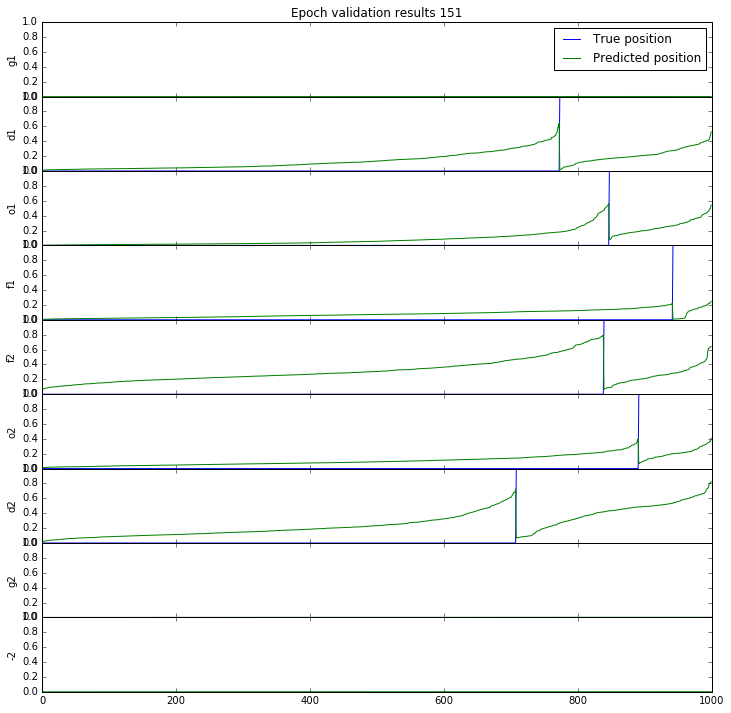

Wrote model to .\ModelsTransfer\weights_151.hdf
Epoch 152/152
88/87 [==============================] - 75s - loss: 1.1361 - categorical_accuracy: 0.5750 - val_loss: 1.4374 - val_categorical_accuracy: 0.4513
Wrote model to .\ModelsTransfer\weights_152.hdf
Epoch 153/153
88/87 [==============================] - 75s - loss: 1.1504 - categorical_accuracy: 0.5674 - val_loss: 1.4309 - val_categorical_accuracy: 0.4885
Wrote model to .\ModelsTransfer\weights_153.hdf
Epoch 154/154
88/87 [==============================] - 75s - loss: 1.1104 - categorical_accuracy: 0.5890 - val_loss: 1.4395 - val_categorical_accuracy: 0.4090
Wrote model to .\ModelsTransfer\weights_154.hdf
Epoch 155/155
88/87 [==============================] - 75s - loss: 1.1120 - categorical_accuracy: 0.5799 - val_loss: 1.4186 - val_categorical_accuracy: 0.4500
Wrote model to .\ModelsTransfer\weights_155.hdf
Epoch 156/156
88/87 [==============================] - 75s - loss: 1.1437 - categorical_accuracy: 0.5652 - val_loss: 1.5565 

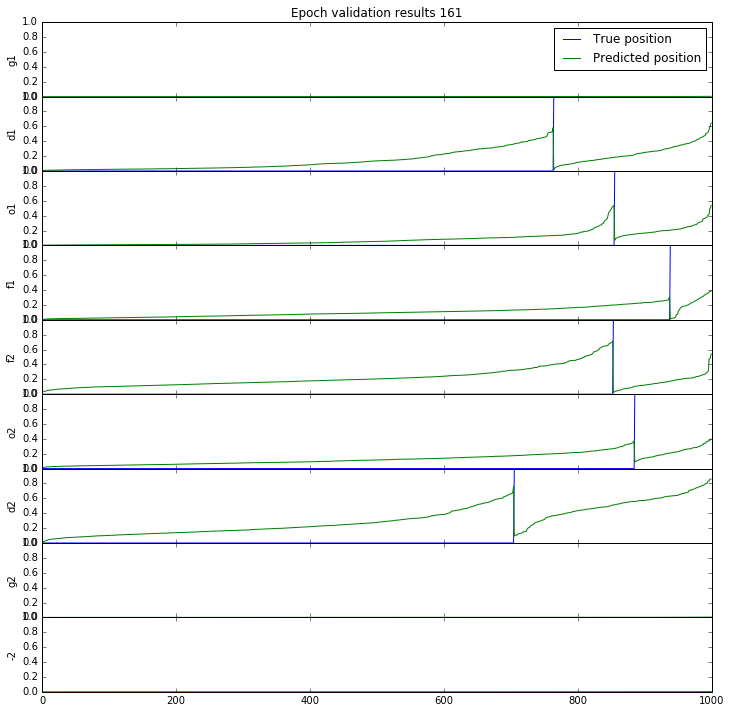

Wrote model to .\ModelsTransfer\weights_161.hdf
Epoch 162/162
88/87 [==============================] - 76s - loss: 1.1180 - categorical_accuracy: 0.5784 - val_loss: 1.4880 - val_categorical_accuracy: 0.3923
Wrote model to .\ModelsTransfer\weights_162.hdf
Epoch 163/163
88/87 [==============================] - 74s - loss: 1.0927 - categorical_accuracy: 0.5871 - val_loss: 1.4042 - val_categorical_accuracy: 0.4974
Wrote model to .\ModelsTransfer\weights_163.hdf
Epoch 164/164
88/87 [==============================] - 74s - loss: 1.1280 - categorical_accuracy: 0.5731 - val_loss: 1.4029 - val_categorical_accuracy: 0.4256
Wrote model to .\ModelsTransfer\weights_164.hdf
Epoch 165/165
88/87 [==============================] - 74s - loss: 1.1289 - categorical_accuracy: 0.5788 - val_loss: 1.4818 - val_categorical_accuracy: 0.4051
Wrote model to .\ModelsTransfer\weights_165.hdf
Epoch 166/166
88/87 [==============================] - 75s - loss: 1.1124 - categorical_accuracy: 0.5917 - val_loss: 1.3777 

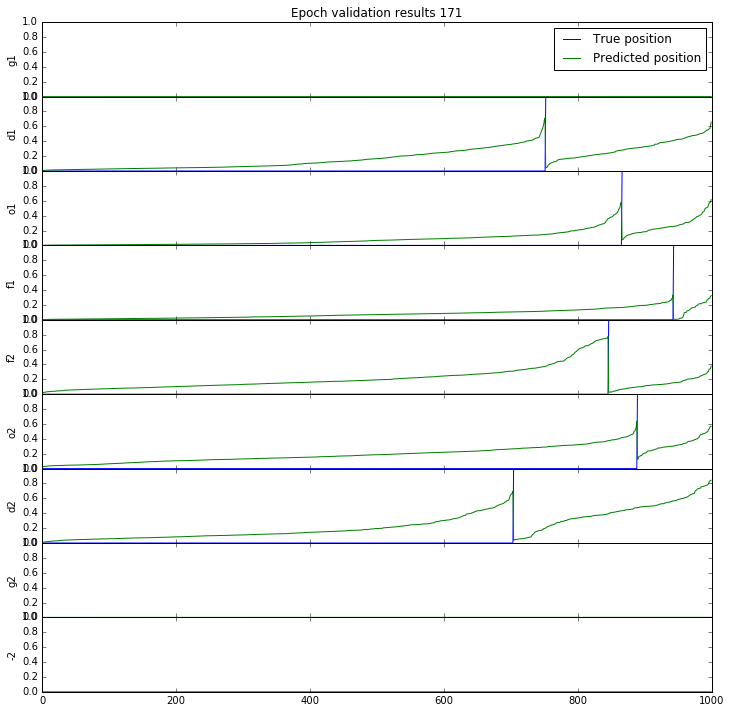

Wrote model to .\ModelsTransfer\weights_171.hdf
Epoch 172/172
88/87 [==============================] - 75s - loss: 1.1199 - categorical_accuracy: 0.5814 - val_loss: 1.3938 - val_categorical_accuracy: 0.4974
Wrote model to .\ModelsTransfer\weights_172.hdf
Epoch 173/173
88/87 [==============================] - 76s - loss: 1.1444 - categorical_accuracy: 0.5667 - val_loss: 1.3772 - val_categorical_accuracy: 0.5013
Wrote model to .\ModelsTransfer\weights_173.hdf
Epoch 174/174
88/87 [==============================] - 75s - loss: 1.0822 - categorical_accuracy: 0.5894 - val_loss: 1.4059 - val_categorical_accuracy: 0.4064
Wrote model to .\ModelsTransfer\weights_174.hdf
Epoch 175/175
88/87 [==============================] - 74s - loss: 1.0900 - categorical_accuracy: 0.5951 - val_loss: 1.4213 - val_categorical_accuracy: 0.4859
Wrote model to .\ModelsTransfer\weights_175.hdf
Epoch 176/176
88/87 [==============================] - 74s - loss: 1.0887 - categorical_accuracy: 0.5962 - val_loss: 1.3896 

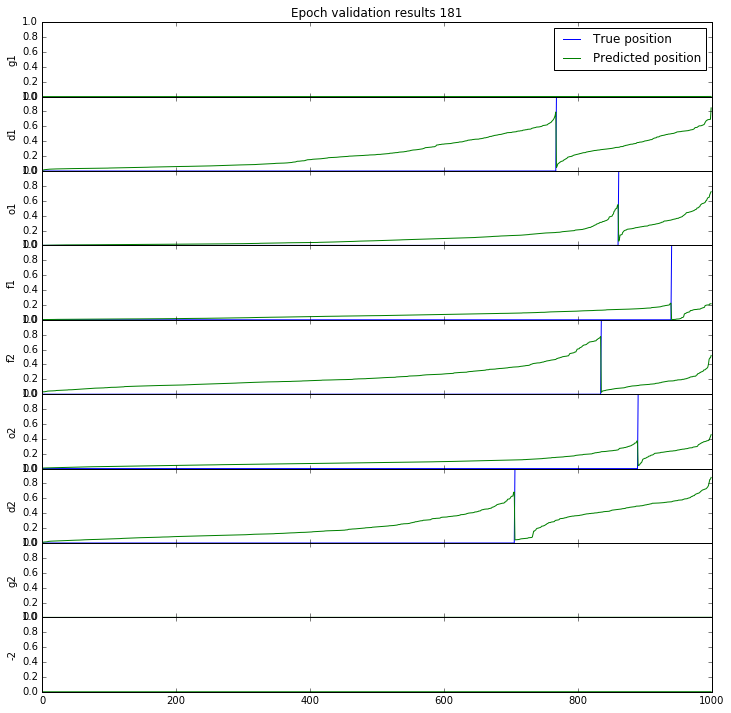

Wrote model to .\ModelsTransfer\weights_181.hdf
Epoch 182/182
88/87 [==============================] - 75s - loss: 1.0870 - categorical_accuracy: 0.5894 - val_loss: 1.3821 - val_categorical_accuracy: 0.4538
Wrote model to .\ModelsTransfer\weights_182.hdf
Epoch 183/183
88/87 [==============================] - 76s - loss: 1.0646 - categorical_accuracy: 0.6121 - val_loss: 1.3596 - val_categorical_accuracy: 0.5038
Wrote model to .\ModelsTransfer\weights_183.hdf
Epoch 184/184
88/87 [==============================] - 74s - loss: 1.0848 - categorical_accuracy: 0.5973 - val_loss: 1.4032 - val_categorical_accuracy: 0.4538
Wrote model to .\ModelsTransfer\weights_184.hdf
Epoch 185/185
88/87 [==============================] - 75s - loss: 1.0705 - categorical_accuracy: 0.6125 - val_loss: 1.4304 - val_categorical_accuracy: 0.4218
Wrote model to .\ModelsTransfer\weights_185.hdf
Epoch 186/186
88/87 [==============================] - 76s - loss: 1.1132 - categorical_accuracy: 0.5788 - val_loss: 1.2949 

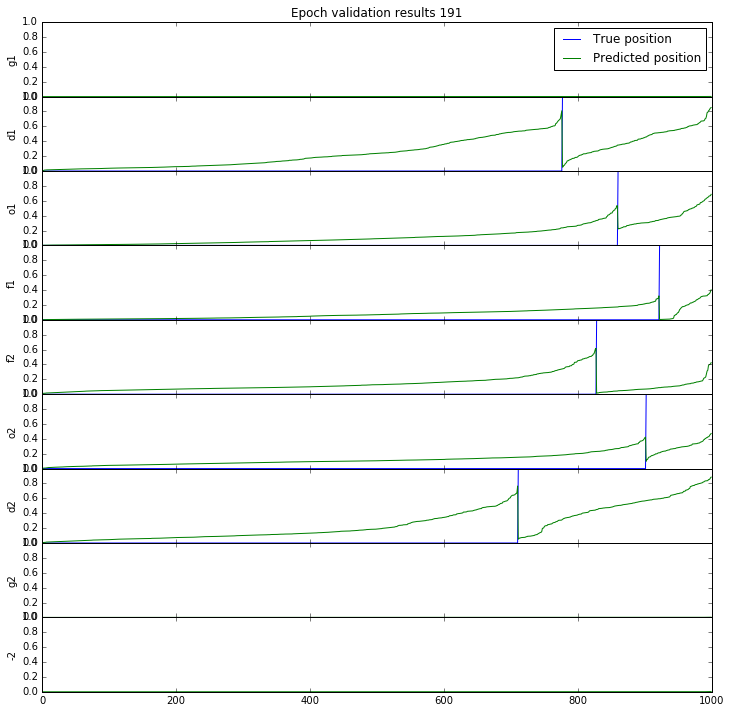

Wrote model to .\ModelsTransfer\weights_191.hdf
Epoch 192/192
88/87 [==============================] - 76s - loss: 1.0590 - categorical_accuracy: 0.6042 - val_loss: 1.3007 - val_categorical_accuracy: 0.4949
Wrote model to .\ModelsTransfer\weights_192.hdf
Epoch 193/193
88/87 [==============================] - 74s - loss: 1.0689 - categorical_accuracy: 0.6049 - val_loss: 1.3091 - val_categorical_accuracy: 0.5115
Wrote model to .\ModelsTransfer\weights_193.hdf
Epoch 194/194
88/87 [==============================] - 76s - loss: 1.0340 - categorical_accuracy: 0.6110 - val_loss: 1.3345 - val_categorical_accuracy: 0.5064
Wrote model to .\ModelsTransfer\weights_194.hdf
Epoch 195/195
88/87 [==============================] - 75s - loss: 1.0230 - categorical_accuracy: 0.6163 - val_loss: 1.2527 - val_categorical_accuracy: 0.5500
Wrote model to .\ModelsTransfer\weights_195.hdf
Epoch 196/196
88/87 [==============================] - 75s - loss: 1.0438 - categorical_accuracy: 0.6061 - val_loss: 1.2385 

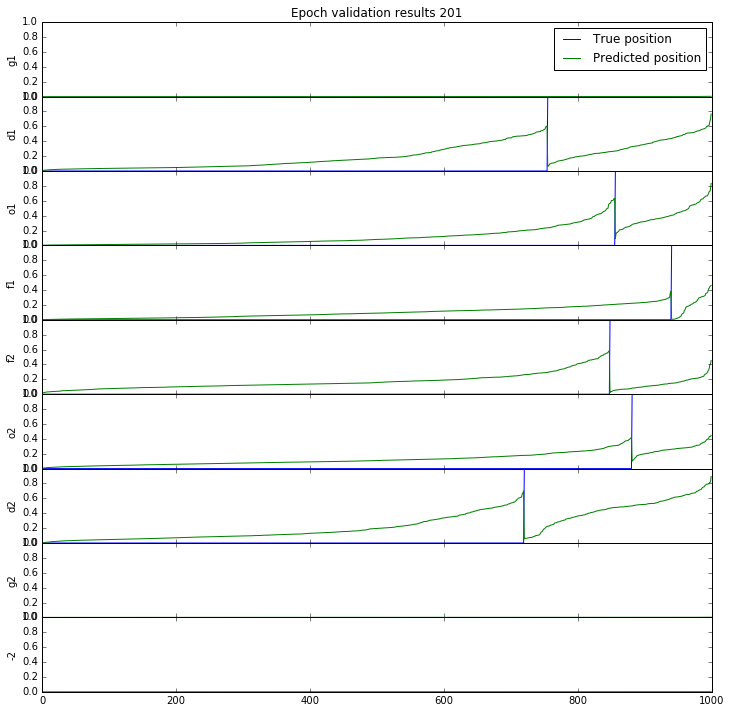

Wrote model to .\ModelsTransfer\weights_201.hdf
Epoch 202/202
88/87 [==============================] - 76s - loss: 1.0440 - categorical_accuracy: 0.6216 - val_loss: 1.3119 - val_categorical_accuracy: 0.5141
Wrote model to .\ModelsTransfer\weights_202.hdf
Epoch 203/203
88/87 [==============================] - 76s - loss: 1.0300 - categorical_accuracy: 0.6265 - val_loss: 1.2853 - val_categorical_accuracy: 0.5551
Wrote model to .\ModelsTransfer\weights_203.hdf
Epoch 204/204
88/87 [==============================] - 75s - loss: 1.0435 - categorical_accuracy: 0.6117 - val_loss: 1.2935 - val_categorical_accuracy: 0.5295
Wrote model to .\ModelsTransfer\weights_204.hdf
Epoch 205/205
88/87 [==============================] - 74s - loss: 1.0275 - categorical_accuracy: 0.6034 - val_loss: 1.2048 - val_categorical_accuracy: 0.5064
Wrote model to .\ModelsTransfer\weights_205.hdf
Epoch 206/206
88/87 [==============================] - 74s - loss: 1.0440 - categorical_accuracy: 0.6027 - val_loss: 1.2701 

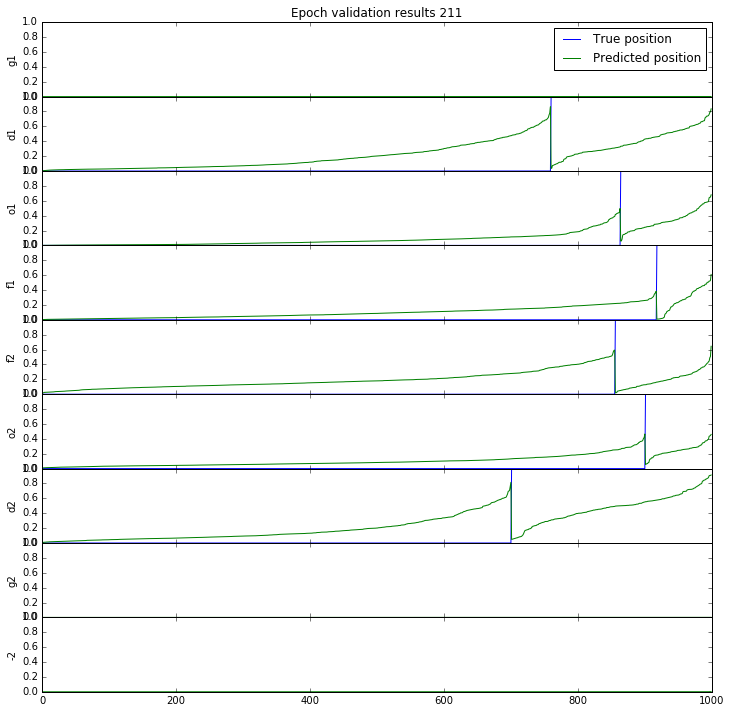

Wrote model to .\ModelsTransfer\weights_211.hdf
Epoch 212/212
88/87 [==============================] - 75s - loss: 1.0119 - categorical_accuracy: 0.6227 - val_loss: 1.2865 - val_categorical_accuracy: 0.5590
Wrote model to .\ModelsTransfer\weights_212.hdf
Epoch 213/213
88/87 [==============================] - 75s - loss: 1.0185 - categorical_accuracy: 0.6242 - val_loss: 1.3112 - val_categorical_accuracy: 0.5295
Wrote model to .\ModelsTransfer\weights_213.hdf
Epoch 214/214
88/87 [==============================] - 75s - loss: 1.0079 - categorical_accuracy: 0.6356 - val_loss: 1.2353 - val_categorical_accuracy: 0.5423
Wrote model to .\ModelsTransfer\weights_214.hdf
Epoch 215/215
88/87 [==============================] - 75s - loss: 1.0154 - categorical_accuracy: 0.6231 - val_loss: 1.2326 - val_categorical_accuracy: 0.5359
Wrote model to .\ModelsTransfer\weights_215.hdf
Epoch 216/216
88/87 [==============================] - 75s - loss: 0.9918 - categorical_accuracy: 0.6292 - val_loss: 1.3038 

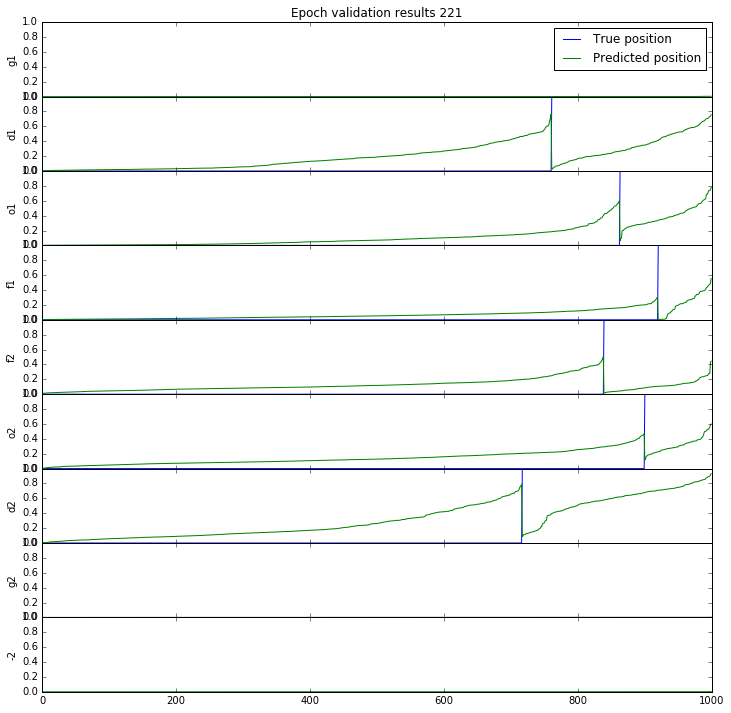

Wrote model to .\ModelsTransfer\weights_221.hdf
Epoch 222/222
88/87 [==============================] - 75s - loss: 0.9905 - categorical_accuracy: 0.6367 - val_loss: 1.3243 - val_categorical_accuracy: 0.5346
Wrote model to .\ModelsTransfer\weights_222.hdf
Epoch 223/223
88/87 [==============================] - 75s - loss: 1.0030 - categorical_accuracy: 0.6231 - val_loss: 1.1840 - val_categorical_accuracy: 0.5679
Wrote model to .\ModelsTransfer\weights_223.hdf
Epoch 224/224
88/87 [==============================] - 76s - loss: 0.9857 - categorical_accuracy: 0.6322 - val_loss: 1.2587 - val_categorical_accuracy: 0.5013
Wrote model to .\ModelsTransfer\weights_224.hdf
Epoch 225/225
88/87 [==============================] - 75s - loss: 0.9688 - categorical_accuracy: 0.6473 - val_loss: 1.2715 - val_categorical_accuracy: 0.5128
Wrote model to .\ModelsTransfer\weights_225.hdf
Epoch 226/226
88/87 [==============================] - 75s - loss: 1.0003 - categorical_accuracy: 0.6277 - val_loss: 1.1902 

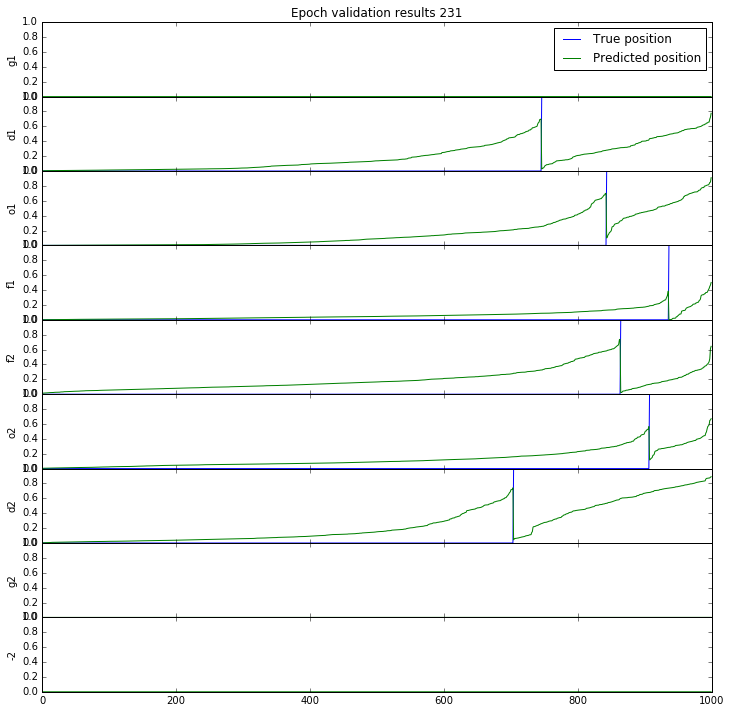

Wrote model to .\ModelsTransfer\weights_231.hdf
Epoch 232/232
88/87 [==============================] - 74s - loss: 0.9860 - categorical_accuracy: 0.6314 - val_loss: 1.1127 - val_categorical_accuracy: 0.5756
Wrote model to .\ModelsTransfer\weights_232.hdf
Epoch 233/233
88/87 [==============================] - 76s - loss: 0.9654 - categorical_accuracy: 0.6462 - val_loss: 1.1487 - val_categorical_accuracy: 0.5731
Wrote model to .\ModelsTransfer\weights_233.hdf
Epoch 234/234
88/87 [==============================] - 75s - loss: 0.9727 - categorical_accuracy: 0.6394 - val_loss: 1.2078 - val_categorical_accuracy: 0.5115
Wrote model to .\ModelsTransfer\weights_234.hdf
Epoch 235/235
88/87 [==============================] - 75s - loss: 0.9445 - categorical_accuracy: 0.6492 - val_loss: 1.2719 - val_categorical_accuracy: 0.5013
Wrote model to .\ModelsTransfer\weights_235.hdf
Epoch 236/236
88/87 [==============================] - 74s - loss: 0.9704 - categorical_accuracy: 0.6436 - val_loss: 1.1232 

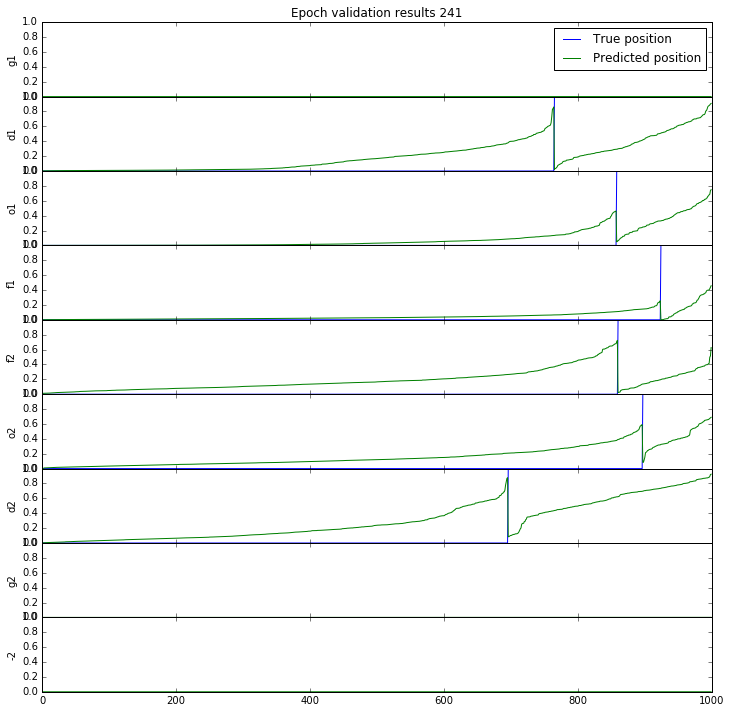

Wrote model to .\ModelsTransfer\weights_241.hdf
Epoch 242/242
88/87 [==============================] - 76s - loss: 0.9528 - categorical_accuracy: 0.6500 - val_loss: 1.1175 - val_categorical_accuracy: 0.5705
Wrote model to .\ModelsTransfer\weights_242.hdf
Epoch 243/243
88/87 [==============================] - 75s - loss: 0.9797 - categorical_accuracy: 0.6451 - val_loss: 1.1263 - val_categorical_accuracy: 0.5551
Wrote model to .\ModelsTransfer\weights_243.hdf
Epoch 244/244
88/87 [==============================] - 75s - loss: 0.9403 - categorical_accuracy: 0.6519 - val_loss: 1.0777 - val_categorical_accuracy: 0.5885
Wrote model to .\ModelsTransfer\weights_244.hdf
Epoch 245/245
88/87 [==============================] - 76s - loss: 0.9733 - categorical_accuracy: 0.6292 - val_loss: 1.1695 - val_categorical_accuracy: 0.5897
Wrote model to .\ModelsTransfer\weights_245.hdf
Epoch 246/246
88/87 [==============================] - 74s - loss: 0.9413 - categorical_accuracy: 0.6561 - val_loss: 1.2106 

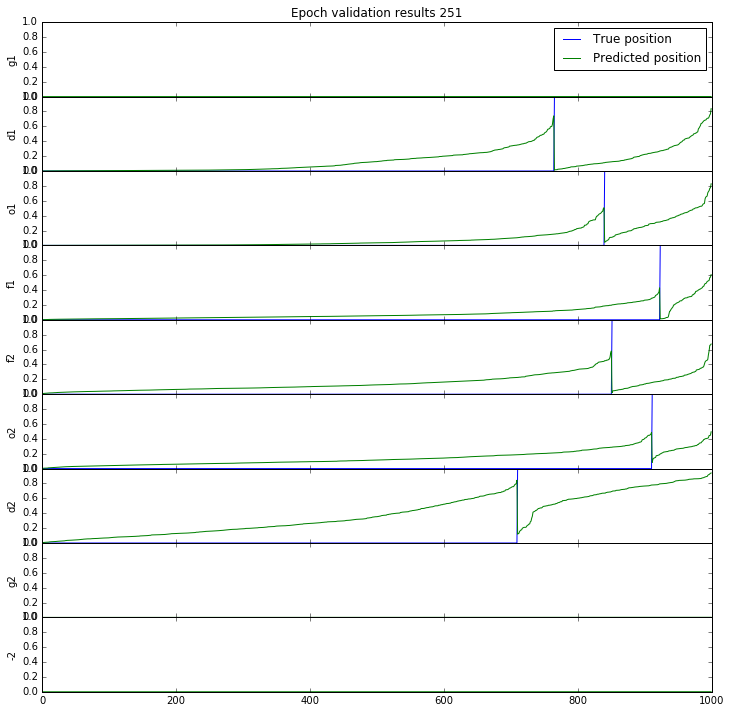

Wrote model to .\ModelsTransfer\weights_251.hdf
Epoch 252/252
88/87 [==============================] - 75s - loss: 0.9406 - categorical_accuracy: 0.6530 - val_loss: 1.3442 - val_categorical_accuracy: 0.4718
Wrote model to .\ModelsTransfer\weights_252.hdf
Epoch 253/253
88/87 [==============================] - 74s - loss: 0.9449 - categorical_accuracy: 0.6447 - val_loss: 1.1235 - val_categorical_accuracy: 0.5679
Wrote model to .\ModelsTransfer\weights_253.hdf
Epoch 254/254
88/87 [==============================] - 74s - loss: 0.9229 - categorical_accuracy: 0.6701 - val_loss: 1.2034 - val_categorical_accuracy: 0.5667
Wrote model to .\ModelsTransfer\weights_254.hdf
Epoch 255/255
88/87 [==============================] - 75s - loss: 0.9461 - categorical_accuracy: 0.6496 - val_loss: 1.2146 - val_categorical_accuracy: 0.5397
Wrote model to .\ModelsTransfer\weights_255.hdf
Epoch 256/256
88/87 [==============================] - 75s - loss: 0.9351 - categorical_accuracy: 0.6633 - val_loss: 1.0824 

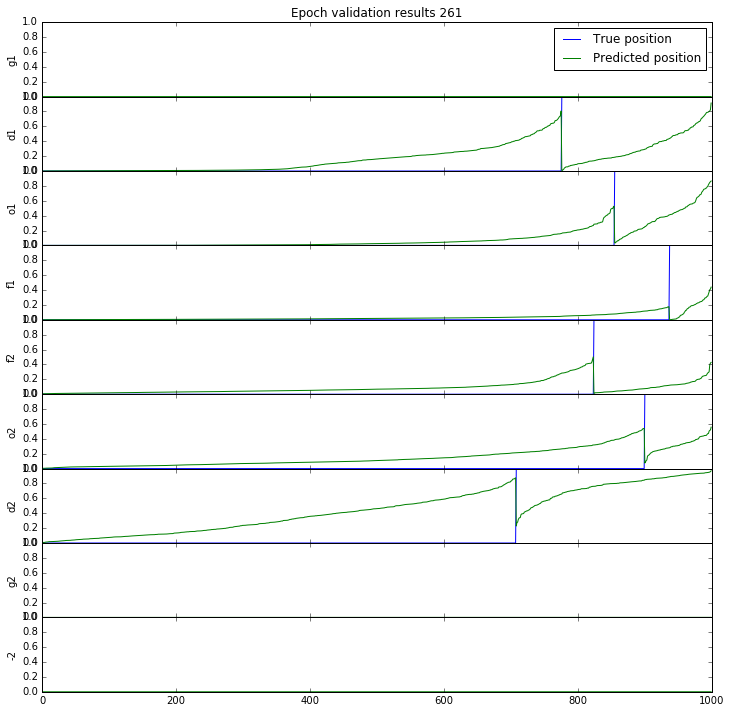

Wrote model to .\ModelsTransfer\weights_261.hdf
Epoch 262/262
88/87 [==============================] - 76s - loss: 0.9226 - categorical_accuracy: 0.6564 - val_loss: 1.1029 - val_categorical_accuracy: 0.5936
Wrote model to .\ModelsTransfer\weights_262.hdf
Epoch 263/263
88/87 [==============================] - 74s - loss: 0.9303 - categorical_accuracy: 0.6576 - val_loss: 1.1502 - val_categorical_accuracy: 0.5500
Wrote model to .\ModelsTransfer\weights_263.hdf
Epoch 264/264
88/87 [==============================] - 75s - loss: 0.9366 - categorical_accuracy: 0.6587 - val_loss: 1.1448 - val_categorical_accuracy: 0.5333
Wrote model to .\ModelsTransfer\weights_264.hdf
Epoch 265/265
88/87 [==============================] - 75s - loss: 0.9250 - categorical_accuracy: 0.6534 - val_loss: 1.1367 - val_categorical_accuracy: 0.5705
Wrote model to .\ModelsTransfer\weights_265.hdf
Epoch 266/266
88/87 [==============================] - 75s - loss: 0.8996 - categorical_accuracy: 0.6746 - val_loss: 1.0981 

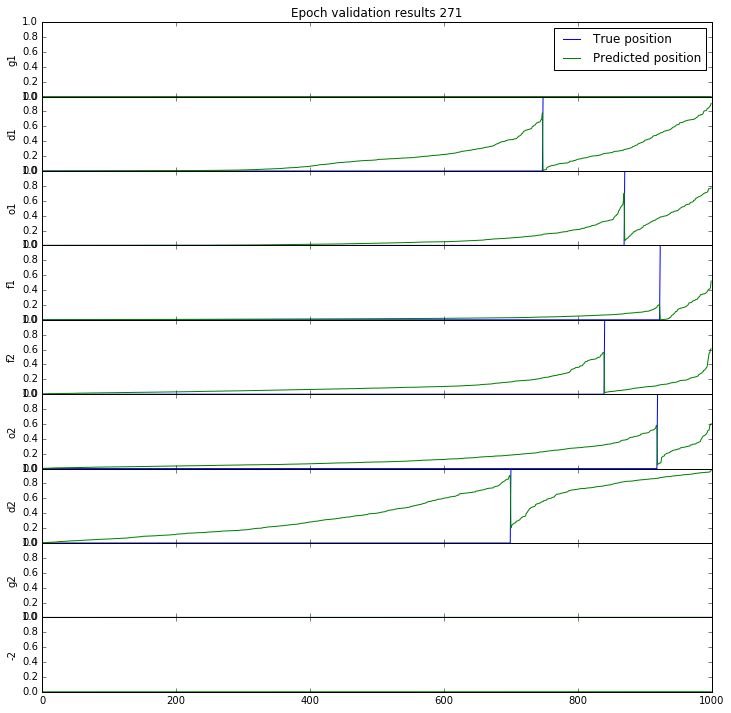

Wrote model to .\ModelsTransfer\weights_271.hdf
Epoch 272/272
88/87 [==============================] - 75s - loss: 0.9181 - categorical_accuracy: 0.6542 - val_loss: 1.0797 - val_categorical_accuracy: 0.6167
Wrote model to .\ModelsTransfer\weights_272.hdf
Epoch 273/273
88/87 [==============================] - 76s - loss: 0.9232 - categorical_accuracy: 0.6663 - val_loss: 1.1631 - val_categorical_accuracy: 0.5654
Wrote model to .\ModelsTransfer\weights_273.hdf
Epoch 274/274
88/87 [==============================] - 75s - loss: 0.9062 - categorical_accuracy: 0.6686 - val_loss: 1.1148 - val_categorical_accuracy: 0.5641
Wrote model to .\ModelsTransfer\weights_274.hdf
Epoch 275/275
88/87 [==============================] - 74s - loss: 0.9063 - categorical_accuracy: 0.6716 - val_loss: 1.1579 - val_categorical_accuracy: 0.5526
Wrote model to .\ModelsTransfer\weights_275.hdf
Epoch 276/276
88/87 [==============================] - 76s - loss: 0.8909 - categorical_accuracy: 0.6678 - val_loss: 1.0918 

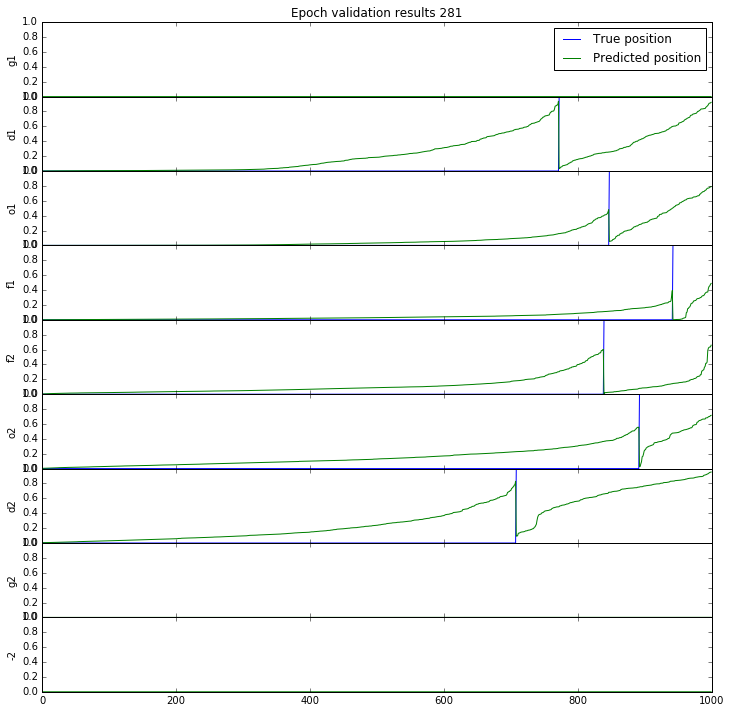

Wrote model to .\ModelsTransfer\weights_281.hdf
Epoch 282/282
88/87 [==============================] - 75s - loss: 0.8919 - categorical_accuracy: 0.6818 - val_loss: 1.0818 - val_categorical_accuracy: 0.6128
Wrote model to .\ModelsTransfer\weights_282.hdf
Epoch 283/283
88/87 [==============================] - 74s - loss: 0.9092 - categorical_accuracy: 0.6712 - val_loss: 1.1013 - val_categorical_accuracy: 0.5782
Wrote model to .\ModelsTransfer\weights_283.hdf
Epoch 284/284
88/87 [==============================] - 74s - loss: 0.8993 - categorical_accuracy: 0.6727 - val_loss: 1.1969 - val_categorical_accuracy: 0.5487
Wrote model to .\ModelsTransfer\weights_284.hdf
Epoch 285/285
88/87 [==============================] - 75s - loss: 0.8932 - categorical_accuracy: 0.6678 - val_loss: 1.2020 - val_categorical_accuracy: 0.5359
Wrote model to .\ModelsTransfer\weights_285.hdf
Epoch 286/286
88/87 [==============================] - 76s - loss: 0.8723 - categorical_accuracy: 0.6754 - val_loss: 1.1828 

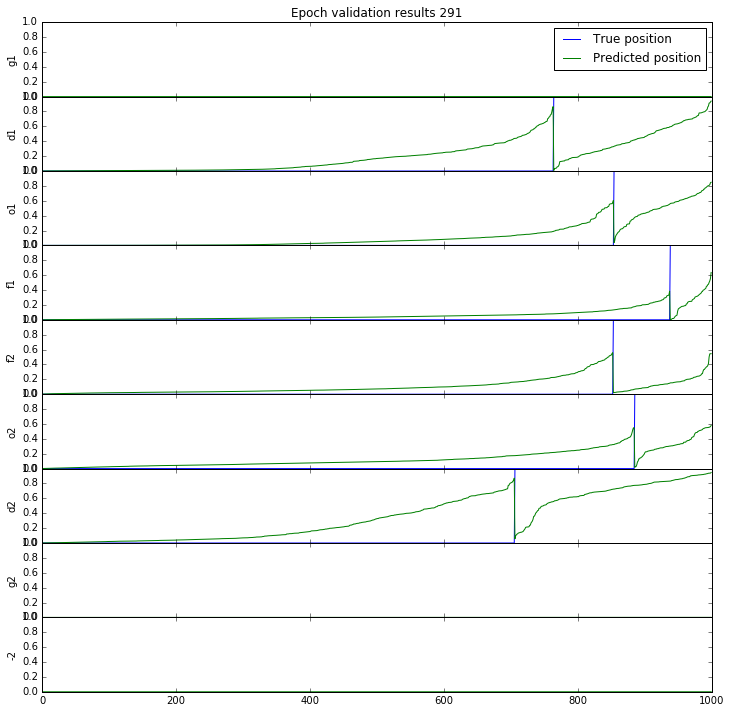

Wrote model to .\ModelsTransfer\weights_291.hdf
Epoch 292/292
88/87 [==============================] - 74s - loss: 0.9066 - categorical_accuracy: 0.6746 - val_loss: 1.1862 - val_categorical_accuracy: 0.5538
Wrote model to .\ModelsTransfer\weights_292.hdf
Epoch 293/293
88/87 [==============================] - 75s - loss: 0.8476 - categorical_accuracy: 0.6867 - val_loss: 1.1576 - val_categorical_accuracy: 0.5615
Wrote model to .\ModelsTransfer\weights_293.hdf
Epoch 294/294
88/87 [==============================] - 74s - loss: 0.8659 - categorical_accuracy: 0.6739 - val_loss: 1.1556 - val_categorical_accuracy: 0.5449
Wrote model to .\ModelsTransfer\weights_294.hdf
Epoch 295/295
88/87 [==============================] - 75s - loss: 0.8824 - categorical_accuracy: 0.6727 - val_loss: 1.2244 - val_categorical_accuracy: 0.5244
Wrote model to .\ModelsTransfer\weights_295.hdf
Epoch 296/296
88/87 [==============================] - 76s - loss: 0.8856 - categorical_accuracy: 0.6712 - val_loss: 1.2424 

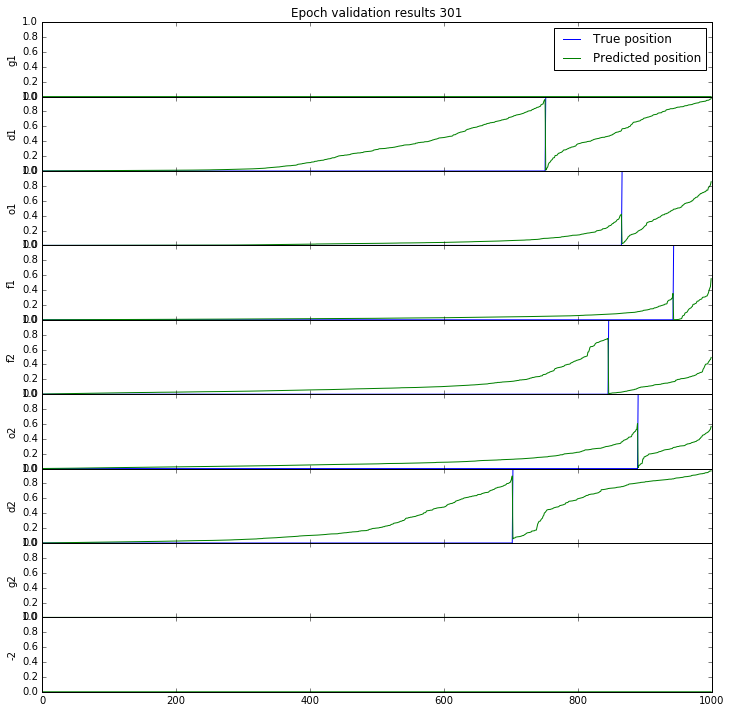

Wrote model to .\ModelsTransfer\weights_301.hdf
Epoch 302/302
88/87 [==============================] - 75s - loss: 0.8587 - categorical_accuracy: 0.6777 - val_loss: 1.1540 - val_categorical_accuracy: 0.5667
Wrote model to .\ModelsTransfer\weights_302.hdf
Epoch 303/303
88/87 [==============================] - 75s - loss: 0.8757 - categorical_accuracy: 0.6761 - val_loss: 1.1874 - val_categorical_accuracy: 0.5808
Wrote model to .\ModelsTransfer\weights_303.hdf
Epoch 304/304
88/87 [==============================] - 77s - loss: 0.8521 - categorical_accuracy: 0.6886 - val_loss: 1.0714 - val_categorical_accuracy: 0.5962
Wrote model to .\ModelsTransfer\weights_304.hdf
Epoch 305/305
88/87 [==============================] - 74s - loss: 0.8768 - categorical_accuracy: 0.6814 - val_loss: 1.1733 - val_categorical_accuracy: 0.5462
Wrote model to .\ModelsTransfer\weights_305.hdf
Epoch 306/306
88/87 [==============================] - 75s - loss: 0.8716 - categorical_accuracy: 0.6788 - val_loss: 1.1313 

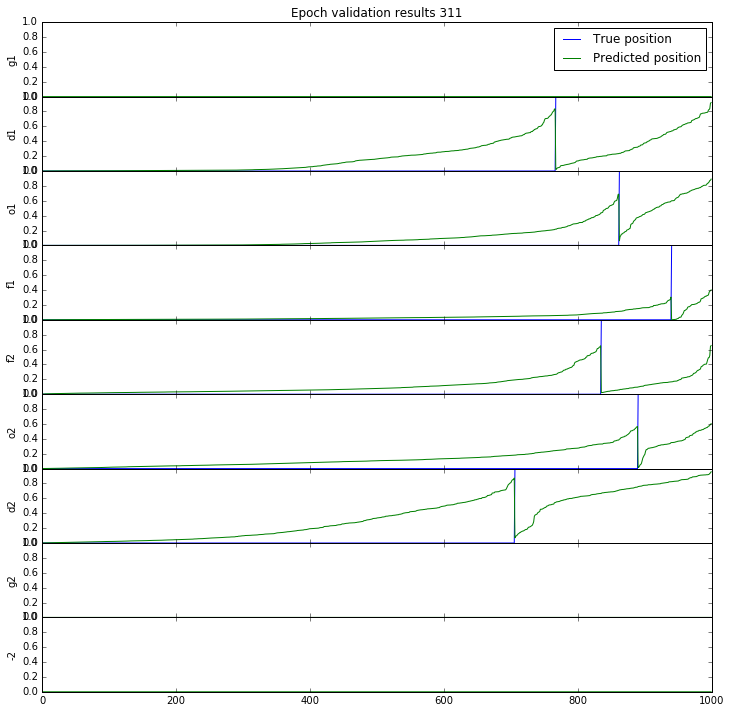

Wrote model to .\ModelsTransfer\weights_311.hdf
Epoch 312/312
88/87 [==============================] - 73s - loss: 0.8604 - categorical_accuracy: 0.6864 - val_loss: 1.1424 - val_categorical_accuracy: 0.5846
Wrote model to .\ModelsTransfer\weights_312.hdf
Epoch 313/313
88/87 [==============================] - 74s - loss: 0.8583 - categorical_accuracy: 0.6879 - val_loss: 1.0670 - val_categorical_accuracy: 0.5718
Wrote model to .\ModelsTransfer\weights_313.hdf
Epoch 314/314
88/87 [==============================] - 74s - loss: 0.8399 - categorical_accuracy: 0.6875 - val_loss: 1.1350 - val_categorical_accuracy: 0.5449
Wrote model to .\ModelsTransfer\weights_314.hdf
Epoch 315/315
88/87 [==============================] - 74s - loss: 0.8320 - categorical_accuracy: 0.6962 - val_loss: 1.2060 - val_categorical_accuracy: 0.4974
Wrote model to .\ModelsTransfer\weights_315.hdf
Epoch 316/316
88/87 [==============================] - 74s - loss: 0.8482 - categorical_accuracy: 0.6848 - val_loss: 1.0537 

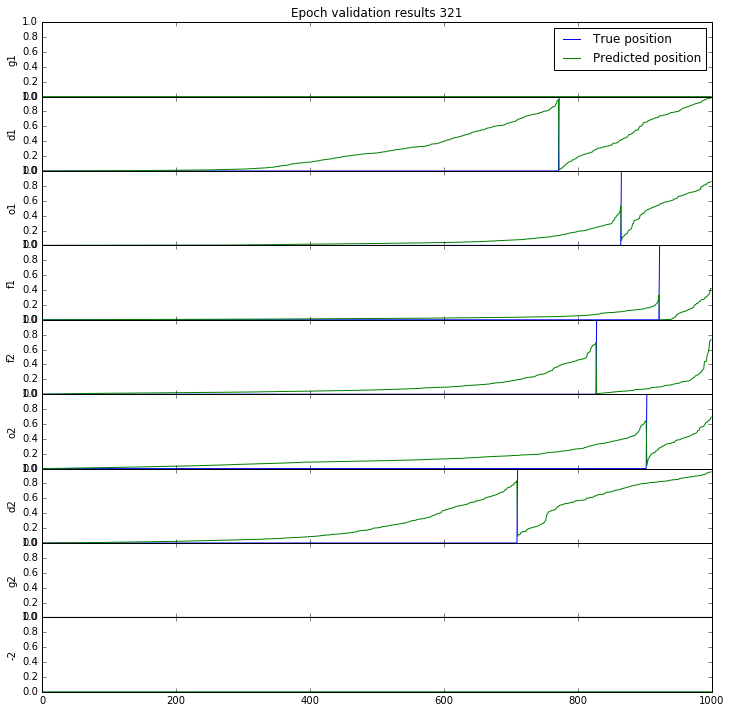

Wrote model to .\ModelsTransfer\weights_321.hdf
Epoch 322/322
88/87 [==============================] - 74s - loss: 0.8564 - categorical_accuracy: 0.6883 - val_loss: 1.0402 - val_categorical_accuracy: 0.5872
Wrote model to .\ModelsTransfer\weights_322.hdf
Epoch 323/323
88/87 [==============================] - 75s - loss: 0.8264 - categorical_accuracy: 0.7027 - val_loss: 1.1390 - val_categorical_accuracy: 0.5410
Wrote model to .\ModelsTransfer\weights_323.hdf
Epoch 324/324
88/87 [==============================] - 76s - loss: 0.8238 - categorical_accuracy: 0.6996 - val_loss: 1.1261 - val_categorical_accuracy: 0.5654
Wrote model to .\ModelsTransfer\weights_324.hdf
Epoch 325/325
88/87 [==============================] - 75s - loss: 0.8729 - categorical_accuracy: 0.6879 - val_loss: 1.1651 - val_categorical_accuracy: 0.5449
Wrote model to .\ModelsTransfer\weights_325.hdf
Epoch 326/326
88/87 [==============================] - 75s - loss: 0.8341 - categorical_accuracy: 0.6943 - val_loss: 1.1550 

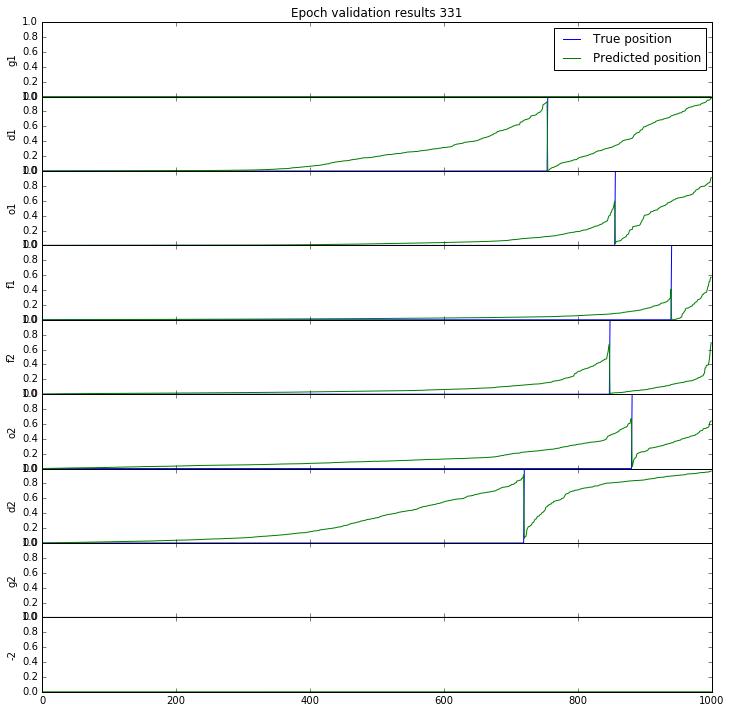

Wrote model to .\ModelsTransfer\weights_331.hdf
Epoch 332/332
88/87 [==============================] - 74s - loss: 0.8572 - categorical_accuracy: 0.6833 - val_loss: 1.1305 - val_categorical_accuracy: 0.5141
Wrote model to .\ModelsTransfer\weights_332.hdf
Epoch 333/333
88/87 [==============================] - 74s - loss: 0.8269 - categorical_accuracy: 0.6985 - val_loss: 1.1245 - val_categorical_accuracy: 0.5500
Wrote model to .\ModelsTransfer\weights_333.hdf
Epoch 334/334
88/87 [==============================] - 73s - loss: 0.8504 - categorical_accuracy: 0.6917 - val_loss: 1.0702 - val_categorical_accuracy: 0.6179
Wrote model to .\ModelsTransfer\weights_334.hdf
Epoch 335/335
88/87 [==============================] - 75s - loss: 0.8380 - categorical_accuracy: 0.6845 - val_loss: 1.0690 - val_categorical_accuracy: 0.5615
Wrote model to .\ModelsTransfer\weights_335.hdf
Epoch 336/336
88/87 [==============================] - 74s - loss: 0.8313 - categorical_accuracy: 0.7068 - val_loss: 1.2134 

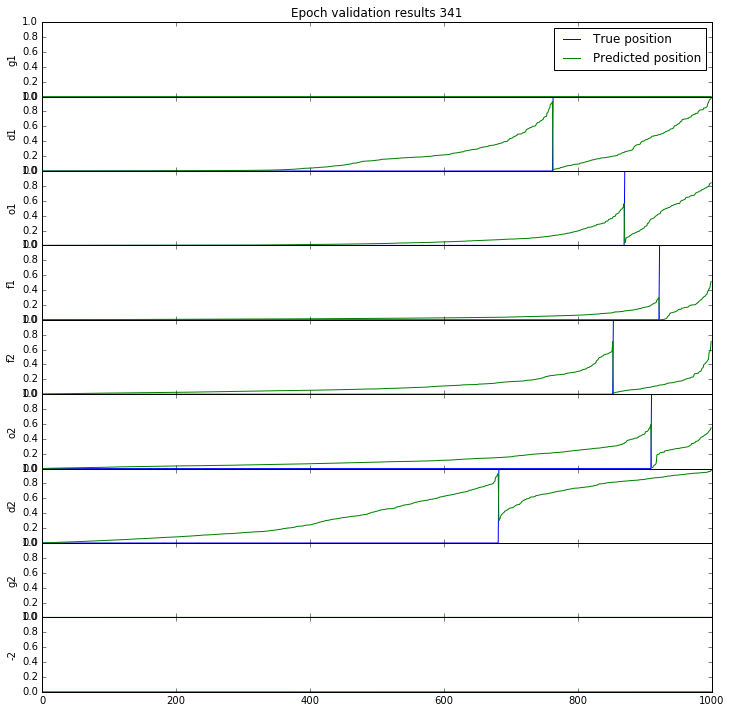

Wrote model to .\ModelsTransfer\weights_341.hdf
Epoch 342/342
88/87 [==============================] - 68s - loss: 0.7867 - categorical_accuracy: 0.7155 - val_loss: 1.0741 - val_categorical_accuracy: 0.5782
Wrote model to .\ModelsTransfer\weights_342.hdf
Epoch 343/343
88/87 [==============================] - 67s - loss: 0.8001 - categorical_accuracy: 0.7091 - val_loss: 1.2041 - val_categorical_accuracy: 0.5641
Wrote model to .\ModelsTransfer\weights_343.hdf
Epoch 344/344
88/87 [==============================] - 67s - loss: 0.8141 - categorical_accuracy: 0.7064 - val_loss: 1.0604 - val_categorical_accuracy: 0.5628
Wrote model to .\ModelsTransfer\weights_344.hdf
Epoch 345/345
88/87 [==============================] - 68s - loss: 0.8107 - categorical_accuracy: 0.7098 - val_loss: 1.2170 - val_categorical_accuracy: 0.5282
Wrote model to .\ModelsTransfer\weights_345.hdf
Epoch 346/346
88/87 [==============================] - 67s - loss: 0.8186 - categorical_accuracy: 0.7015 - val_loss: 1.2767 

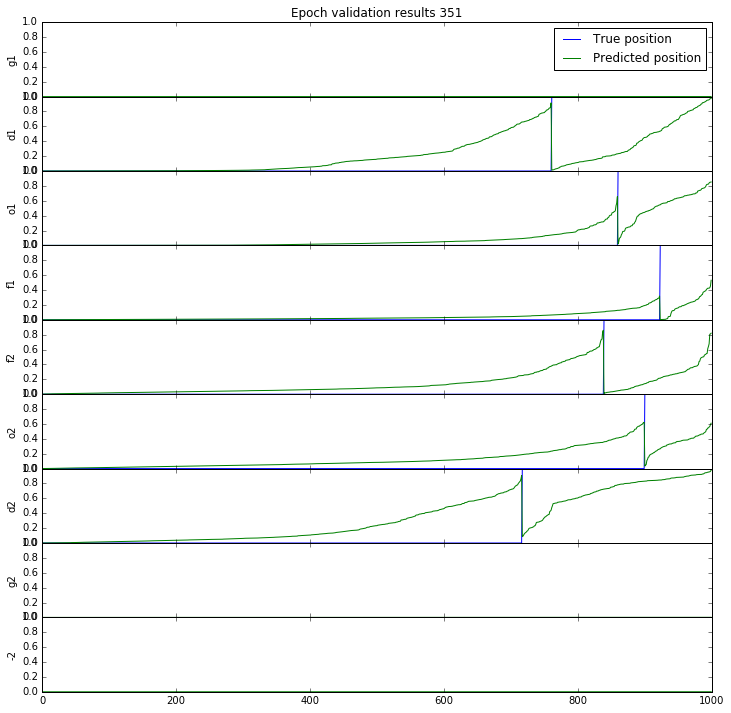

Wrote model to .\ModelsTransfer\weights_351.hdf
Epoch 352/352
88/87 [==============================] - 68s - loss: 0.8011 - categorical_accuracy: 0.7125 - val_loss: 1.1327 - val_categorical_accuracy: 0.5897
Wrote model to .\ModelsTransfer\weights_352.hdf
Epoch 353/353
88/87 [==============================] - 68s - loss: 0.8112 - categorical_accuracy: 0.7102 - val_loss: 1.1575 - val_categorical_accuracy: 0.5449
Wrote model to .\ModelsTransfer\weights_353.hdf
Epoch 354/354
88/87 [==============================] - 68s - loss: 0.7953 - categorical_accuracy: 0.7061 - val_loss: 1.1868 - val_categorical_accuracy: 0.5308
Wrote model to .\ModelsTransfer\weights_354.hdf
Epoch 355/355
88/87 [==============================] - 68s - loss: 0.7819 - categorical_accuracy: 0.7216 - val_loss: 1.2398 - val_categorical_accuracy: 0.5731
Wrote model to .\ModelsTransfer\weights_355.hdf
Epoch 356/356
88/87 [==============================] - 67s - loss: 0.7936 - categorical_accuracy: 0.7053 - val_loss: 1.1222 

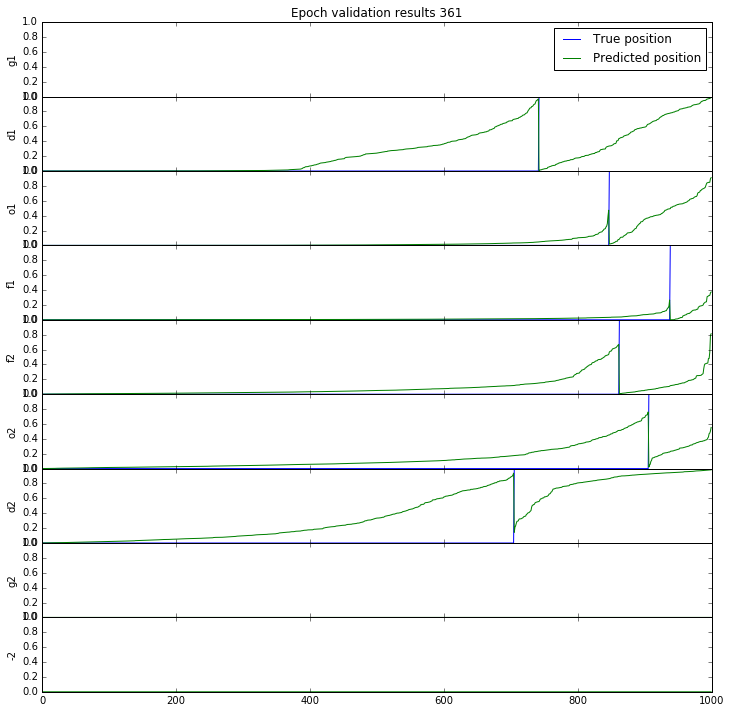

Wrote model to .\ModelsTransfer\weights_361.hdf
Epoch 362/362
88/87 [==============================] - 67s - loss: 0.7860 - categorical_accuracy: 0.7140 - val_loss: 1.2775 - val_categorical_accuracy: 0.4769
Wrote model to .\ModelsTransfer\weights_362.hdf
Epoch 363/363
88/87 [==============================] - 68s - loss: 0.7791 - categorical_accuracy: 0.7186 - val_loss: 1.1023 - val_categorical_accuracy: 0.5756
Wrote model to .\ModelsTransfer\weights_363.hdf
Epoch 364/364
88/87 [==============================] - 68s - loss: 0.7965 - categorical_accuracy: 0.7068 - val_loss: 1.1830 - val_categorical_accuracy: 0.5910
Wrote model to .\ModelsTransfer\weights_364.hdf
Epoch 365/365
88/87 [==============================] - 67s - loss: 0.7776 - categorical_accuracy: 0.7114 - val_loss: 1.3775 - val_categorical_accuracy: 0.5013
Wrote model to .\ModelsTransfer\weights_365.hdf
Epoch 366/366
88/87 [==============================] - 67s - loss: 0.7861 - categorical_accuracy: 0.7201 - val_loss: 1.1660 

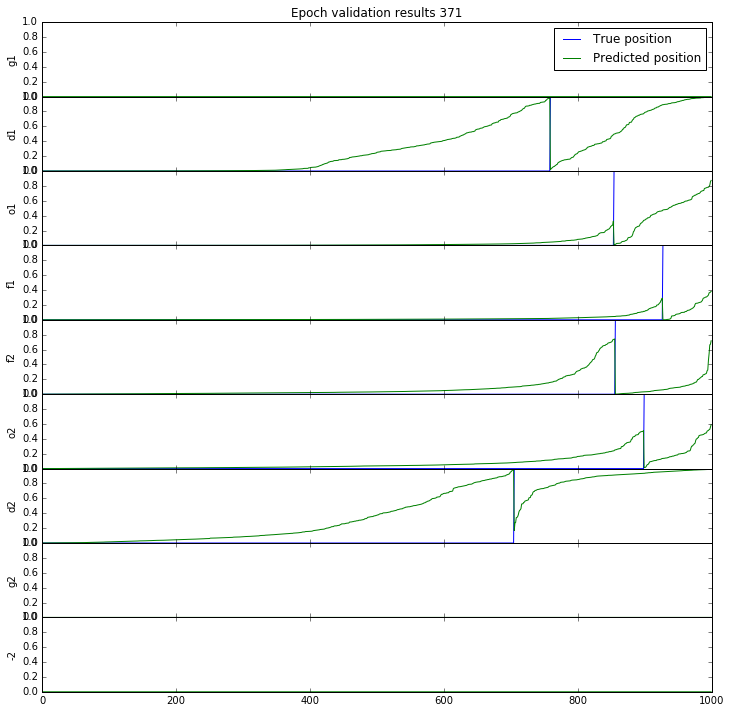

Wrote model to .\ModelsTransfer\weights_371.hdf
Epoch 372/372
88/87 [==============================] - 67s - loss: 0.7956 - categorical_accuracy: 0.7042 - val_loss: 1.0550 - val_categorical_accuracy: 0.6064
Wrote model to .\ModelsTransfer\weights_372.hdf
Epoch 373/373
88/87 [==============================] - 67s - loss: 0.7827 - categorical_accuracy: 0.7106 - val_loss: 1.2370 - val_categorical_accuracy: 0.5500
Wrote model to .\ModelsTransfer\weights_373.hdf
Epoch 374/374
88/87 [==============================] - 67s - loss: 0.7510 - categorical_accuracy: 0.7284 - val_loss: 1.1462 - val_categorical_accuracy: 0.5385
Wrote model to .\ModelsTransfer\weights_374.hdf
Epoch 375/375
88/87 [==============================] - 68s - loss: 0.8133 - categorical_accuracy: 0.6996 - val_loss: 1.1586 - val_categorical_accuracy: 0.5846
Wrote model to .\ModelsTransfer\weights_375.hdf
Epoch 376/376
88/87 [==============================] - 67s - loss: 0.7567 - categorical_accuracy: 0.7227 - val_loss: 1.1852 

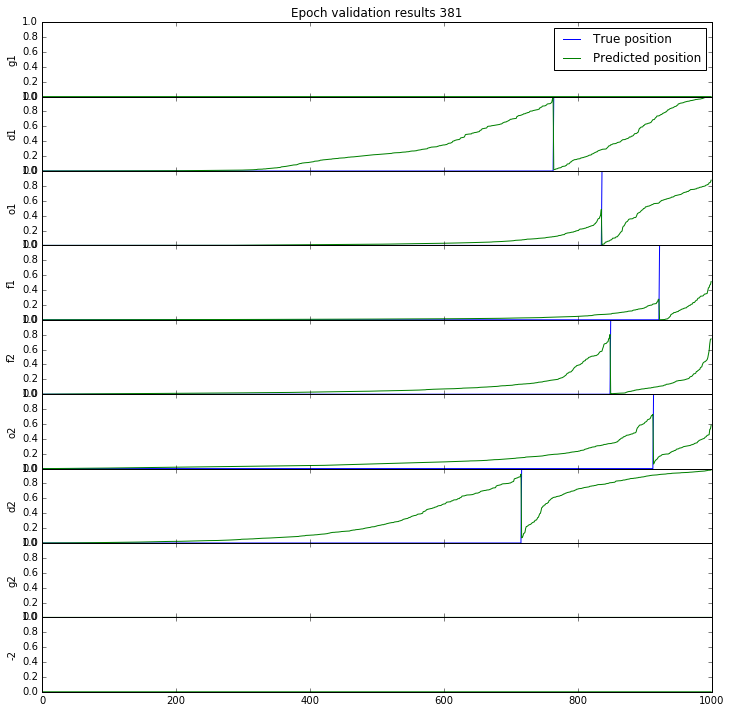

Wrote model to .\ModelsTransfer\weights_381.hdf
Epoch 382/382
88/87 [==============================] - 67s - loss: 0.7626 - categorical_accuracy: 0.7205 - val_loss: 1.1321 - val_categorical_accuracy: 0.5718
Wrote model to .\ModelsTransfer\weights_382.hdf
Epoch 383/383
88/87 [==============================] - 68s - loss: 0.7759 - categorical_accuracy: 0.7155 - val_loss: 1.0860 - val_categorical_accuracy: 0.5962
Wrote model to .\ModelsTransfer\weights_383.hdf
Epoch 384/384
88/87 [==============================] - 68s - loss: 0.7896 - categorical_accuracy: 0.7015 - val_loss: 1.2611 - val_categorical_accuracy: 0.5679
Wrote model to .\ModelsTransfer\weights_384.hdf
Epoch 385/385
88/87 [==============================] - 68s - loss: 0.7982 - categorical_accuracy: 0.7061 - val_loss: 1.1772 - val_categorical_accuracy: 0.5538
Wrote model to .\ModelsTransfer\weights_385.hdf
Epoch 386/386
88/87 [==============================] - 68s - loss: 0.7433 - categorical_accuracy: 0.7284 - val_loss: 1.0476 

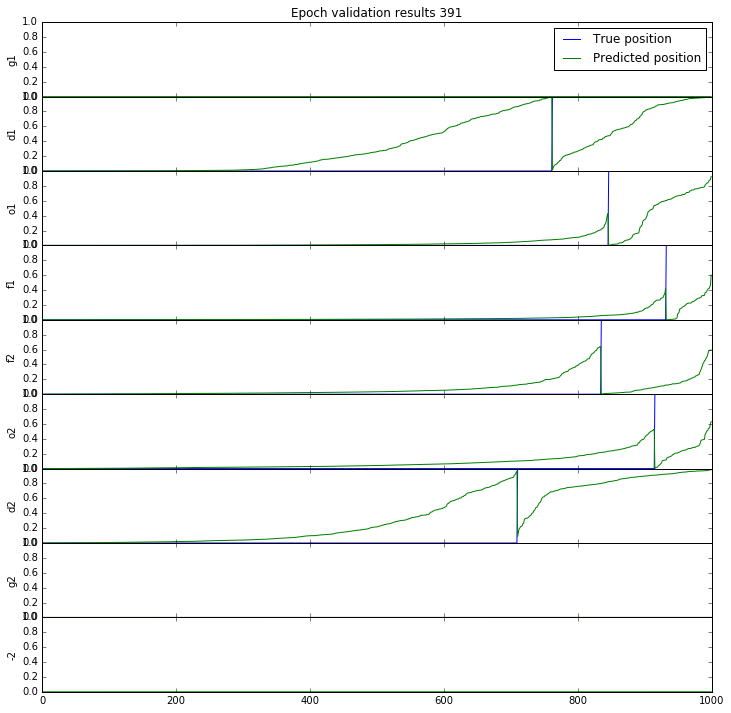

Wrote model to .\ModelsTransfer\weights_391.hdf
Epoch 392/392
88/87 [==============================] - 67s - loss: 0.7488 - categorical_accuracy: 0.7292 - val_loss: 1.0336 - val_categorical_accuracy: 0.5949
Wrote model to .\ModelsTransfer\weights_392.hdf
Epoch 393/393
88/87 [==============================] - 68s - loss: 0.7960 - categorical_accuracy: 0.7197 - val_loss: 1.0857 - val_categorical_accuracy: 0.6218
Wrote model to .\ModelsTransfer\weights_393.hdf
Epoch 394/394
88/87 [==============================] - 67s - loss: 0.7394 - categorical_accuracy: 0.7254 - val_loss: 1.1311 - val_categorical_accuracy: 0.5962
Wrote model to .\ModelsTransfer\weights_394.hdf
Epoch 395/395
88/87 [==============================] - 67s - loss: 0.7578 - categorical_accuracy: 0.7223 - val_loss: 1.0944 - val_categorical_accuracy: 0.5923
Wrote model to .\ModelsTransfer\weights_395.hdf
Epoch 396/396
88/87 [==============================] - 68s - loss: 0.7559 - categorical_accuracy: 0.7201 - val_loss: 1.1805 

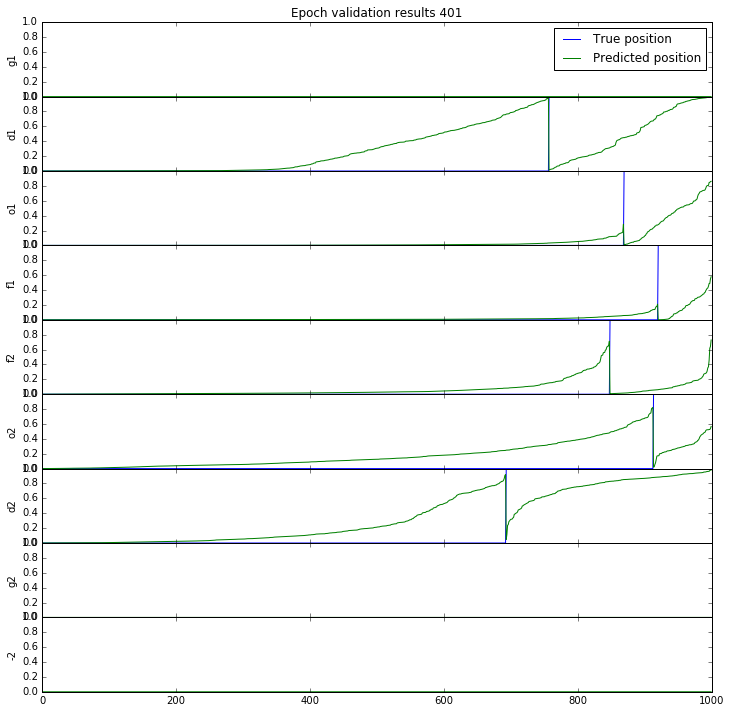

Wrote model to .\ModelsTransfer\weights_401.hdf
Epoch 402/402
88/87 [==============================] - 68s - loss: 0.7325 - categorical_accuracy: 0.7413 - val_loss: 1.0771 - val_categorical_accuracy: 0.5833
Wrote model to .\ModelsTransfer\weights_402.hdf
Epoch 403/403
88/87 [==============================] - 68s - loss: 0.7483 - categorical_accuracy: 0.7322 - val_loss: 1.0618 - val_categorical_accuracy: 0.5705
Wrote model to .\ModelsTransfer\weights_403.hdf
Epoch 404/404
88/87 [==============================] - 68s - loss: 0.7490 - categorical_accuracy: 0.7409 - val_loss: 0.9894 - val_categorical_accuracy: 0.6141
Wrote model to .\ModelsTransfer\weights_404.hdf
Epoch 405/405
88/87 [==============================] - 68s - loss: 0.7443 - categorical_accuracy: 0.7265 - val_loss: 1.1350 - val_categorical_accuracy: 0.5859
Wrote model to .\ModelsTransfer\weights_405.hdf
Epoch 406/406
88/87 [==============================] - 67s - loss: 0.7310 - categorical_accuracy: 0.7333 - val_loss: 1.0475 

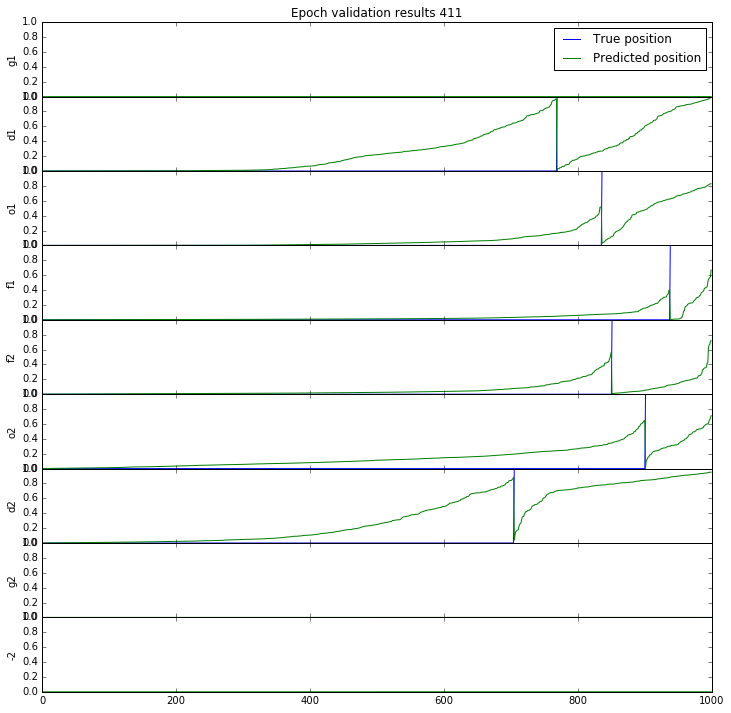

Wrote model to .\ModelsTransfer\weights_411.hdf
Epoch 412/412
88/87 [==============================] - 67s - loss: 0.7268 - categorical_accuracy: 0.7311 - val_loss: 1.1797 - val_categorical_accuracy: 0.5564
Wrote model to .\ModelsTransfer\weights_412.hdf
Epoch 413/413
88/87 [==============================] - 67s - loss: 0.7435 - categorical_accuracy: 0.7277 - val_loss: 1.0880 - val_categorical_accuracy: 0.5923
Wrote model to .\ModelsTransfer\weights_413.hdf
Epoch 414/414
88/87 [==============================] - 68s - loss: 0.7238 - categorical_accuracy: 0.7348 - val_loss: 1.0623 - val_categorical_accuracy: 0.5987
Wrote model to .\ModelsTransfer\weights_414.hdf
Epoch 415/415
88/87 [==============================] - 68s - loss: 0.7588 - categorical_accuracy: 0.7242 - val_loss: 1.1158 - val_categorical_accuracy: 0.5756
Wrote model to .\ModelsTransfer\weights_415.hdf
Epoch 416/416
88/87 [==============================] - 68s - loss: 0.7845 - categorical_accuracy: 0.7045 - val_loss: 1.2066 

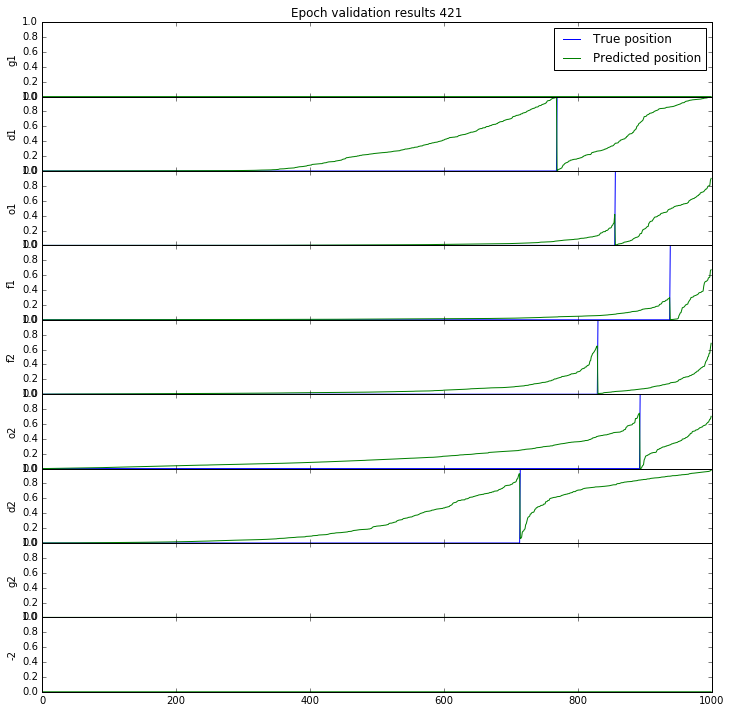

Wrote model to .\ModelsTransfer\weights_421.hdf
Epoch 422/422
88/87 [==============================] - 68s - loss: 0.7321 - categorical_accuracy: 0.7254 - val_loss: 1.1570 - val_categorical_accuracy: 0.5615
Wrote model to .\ModelsTransfer\weights_422.hdf
Epoch 423/423
88/87 [==============================] - 68s - loss: 0.7309 - categorical_accuracy: 0.7352 - val_loss: 1.0200 - val_categorical_accuracy: 0.6038
Wrote model to .\ModelsTransfer\weights_423.hdf
Epoch 424/424
88/87 [==============================] - 68s - loss: 0.7334 - categorical_accuracy: 0.7367 - val_loss: 1.0117 - val_categorical_accuracy: 0.6090
Wrote model to .\ModelsTransfer\weights_424.hdf
Epoch 425/425
88/87 [==============================] - 67s - loss: 0.7436 - categorical_accuracy: 0.7348 - val_loss: 1.1821 - val_categorical_accuracy: 0.5782
Wrote model to .\ModelsTransfer\weights_425.hdf
Epoch 426/426
88/87 [==============================] - 67s - loss: 0.7565 - categorical_accuracy: 0.7239 - val_loss: 1.3104 

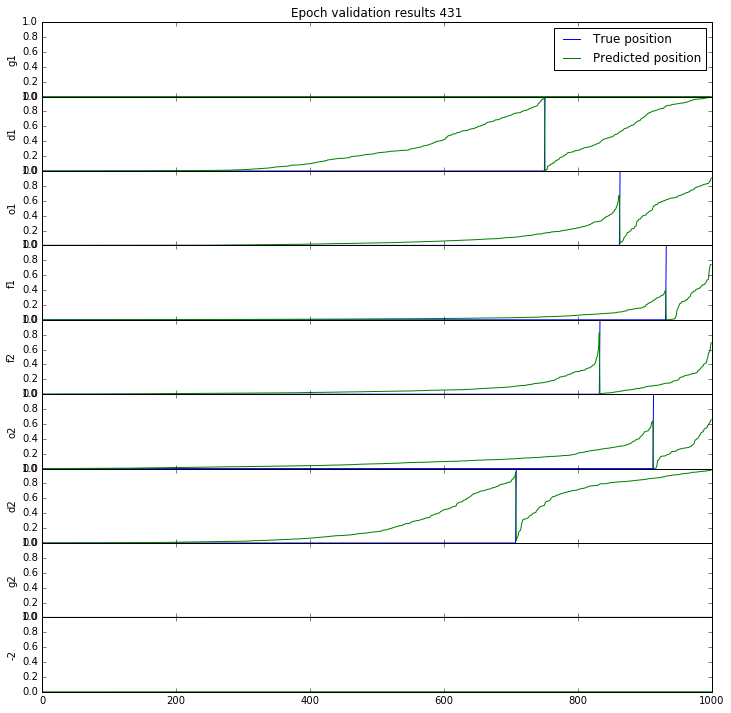

Wrote model to .\ModelsTransfer\weights_431.hdf
Epoch 432/432
88/87 [==============================] - 67s - loss: 0.6869 - categorical_accuracy: 0.7500 - val_loss: 1.2694 - val_categorical_accuracy: 0.5474
Wrote model to .\ModelsTransfer\weights_432.hdf
Epoch 433/433
88/87 [==============================] - 67s - loss: 0.7177 - categorical_accuracy: 0.7303 - val_loss: 1.2108 - val_categorical_accuracy: 0.5346
Wrote model to .\ModelsTransfer\weights_433.hdf
Epoch 434/434
88/87 [==============================] - 68s - loss: 0.7188 - categorical_accuracy: 0.7223 - val_loss: 1.3107 - val_categorical_accuracy: 0.5115
Wrote model to .\ModelsTransfer\weights_434.hdf
Epoch 435/435
88/87 [==============================] - 68s - loss: 0.7475 - categorical_accuracy: 0.7303 - val_loss: 1.0787 - val_categorical_accuracy: 0.5923
Wrote model to .\ModelsTransfer\weights_435.hdf
Epoch 436/436
88/87 [==============================] - 67s - loss: 0.6845 - categorical_accuracy: 0.7572 - val_loss: 1.1508 

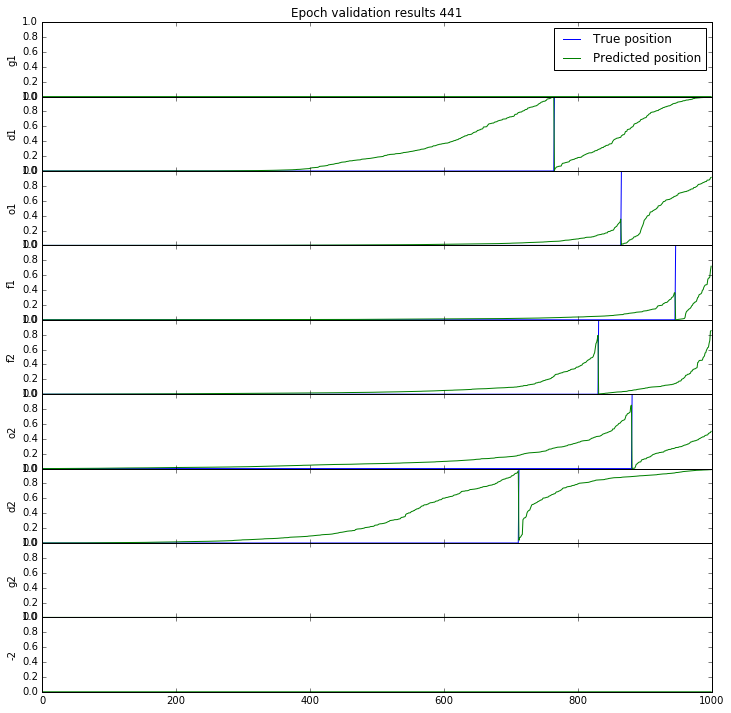

Wrote model to .\ModelsTransfer\weights_441.hdf
Epoch 442/442
88/87 [==============================] - 67s - loss: 0.7220 - categorical_accuracy: 0.7295 - val_loss: 1.0706 - val_categorical_accuracy: 0.5872
Wrote model to .\ModelsTransfer\weights_442.hdf
Epoch 443/443
88/87 [==============================] - 67s - loss: 0.7176 - categorical_accuracy: 0.7383 - val_loss: 1.1871 - val_categorical_accuracy: 0.5423
Wrote model to .\ModelsTransfer\weights_443.hdf
Epoch 444/444
88/87 [==============================] - 67s - loss: 0.7093 - categorical_accuracy: 0.7447 - val_loss: 1.1125 - val_categorical_accuracy: 0.5833
Wrote model to .\ModelsTransfer\weights_444.hdf
Epoch 445/445
88/87 [==============================] - 67s - loss: 0.7157 - categorical_accuracy: 0.7420 - val_loss: 1.0133 - val_categorical_accuracy: 0.6385
Wrote model to .\ModelsTransfer\weights_445.hdf
Epoch 446/446
88/87 [==============================] - 68s - loss: 0.7049 - categorical_accuracy: 0.7568 - val_loss: 1.0469 

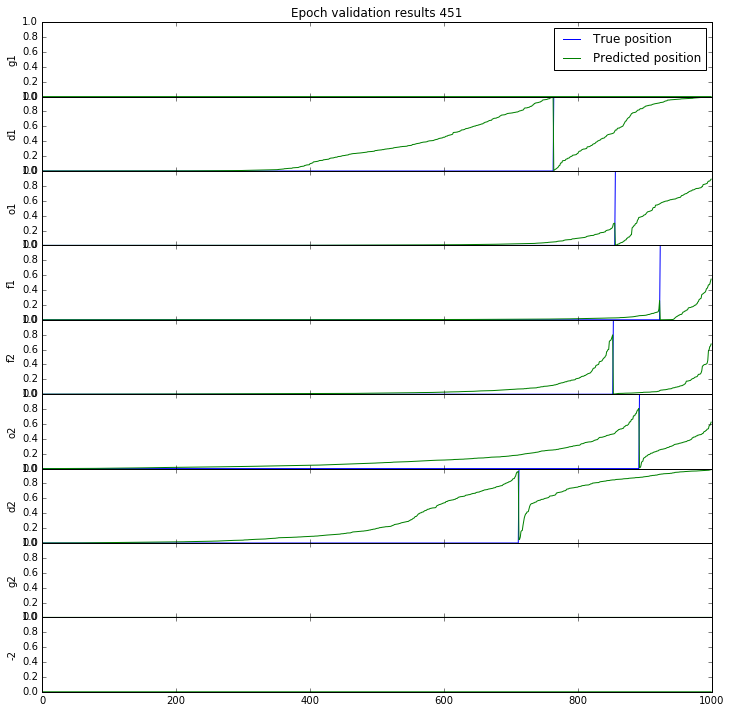

Wrote model to .\ModelsTransfer\weights_451.hdf
Epoch 452/452
88/87 [==============================] - 68s - loss: 0.7081 - categorical_accuracy: 0.7333 - val_loss: 1.2740 - val_categorical_accuracy: 0.5397
Wrote model to .\ModelsTransfer\weights_452.hdf
Epoch 453/453
88/87 [==============================] - 67s - loss: 0.7123 - categorical_accuracy: 0.7409 - val_loss: 1.1388 - val_categorical_accuracy: 0.5692
Wrote model to .\ModelsTransfer\weights_453.hdf
Epoch 454/454
88/87 [==============================] - 67s - loss: 0.7073 - categorical_accuracy: 0.7439 - val_loss: 1.0914 - val_categorical_accuracy: 0.5821
Wrote model to .\ModelsTransfer\weights_454.hdf
Epoch 455/455
88/87 [==============================] - 67s - loss: 0.7208 - categorical_accuracy: 0.7326 - val_loss: 1.0239 - val_categorical_accuracy: 0.6103
Wrote model to .\ModelsTransfer\weights_455.hdf
Epoch 456/456
88/87 [==============================] - 67s - loss: 0.7036 - categorical_accuracy: 0.7439 - val_loss: 1.1577 

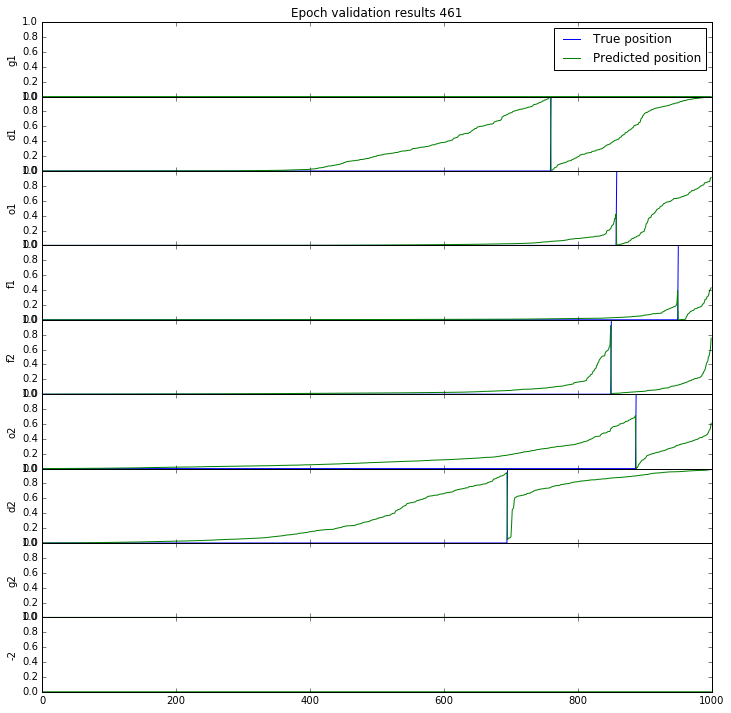

Wrote model to .\ModelsTransfer\weights_461.hdf
Epoch 462/462
88/87 [==============================] - 68s - loss: 0.7061 - categorical_accuracy: 0.7420 - val_loss: 1.4202 - val_categorical_accuracy: 0.5487
Wrote model to .\ModelsTransfer\weights_462.hdf
Epoch 463/463
88/87 [==============================] - 67s - loss: 0.7486 - categorical_accuracy: 0.7307 - val_loss: 1.1541 - val_categorical_accuracy: 0.5705
Wrote model to .\ModelsTransfer\weights_463.hdf
Epoch 464/464
88/87 [==============================] - 67s - loss: 0.6894 - categorical_accuracy: 0.7477 - val_loss: 1.1351 - val_categorical_accuracy: 0.5628
Wrote model to .\ModelsTransfer\weights_464.hdf
Epoch 465/465
88/87 [==============================] - 67s - loss: 0.7282 - categorical_accuracy: 0.7326 - val_loss: 1.0510 - val_categorical_accuracy: 0.6192
Wrote model to .\ModelsTransfer\weights_465.hdf
Epoch 466/466
88/87 [==============================] - 67s - loss: 0.6684 - categorical_accuracy: 0.7530 - val_loss: 1.2462 

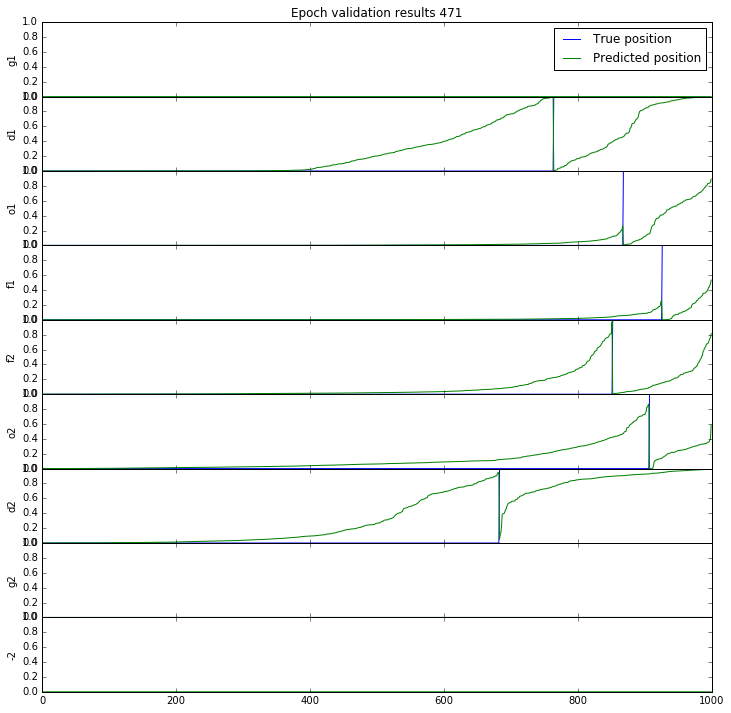

Wrote model to .\ModelsTransfer\weights_471.hdf
Epoch 472/472
88/87 [==============================] - 67s - loss: 0.6662 - categorical_accuracy: 0.7614 - val_loss: 1.2561 - val_categorical_accuracy: 0.5628
Wrote model to .\ModelsTransfer\weights_472.hdf
Epoch 473/473
88/87 [==============================] - 68s - loss: 0.6989 - categorical_accuracy: 0.7405 - val_loss: 1.0716 - val_categorical_accuracy: 0.6295
Wrote model to .\ModelsTransfer\weights_473.hdf
Epoch 474/474
88/87 [==============================] - 67s - loss: 0.6781 - categorical_accuracy: 0.7602 - val_loss: 1.1720 - val_categorical_accuracy: 0.5692
Wrote model to .\ModelsTransfer\weights_474.hdf
Epoch 475/475
88/87 [==============================] - 68s - loss: 0.6812 - categorical_accuracy: 0.7477 - val_loss: 1.1718 - val_categorical_accuracy: 0.5603
Wrote model to .\ModelsTransfer\weights_475.hdf
Epoch 476/476
88/87 [==============================] - 67s - loss: 0.6754 - categorical_accuracy: 0.7549 - val_loss: 1.0495 

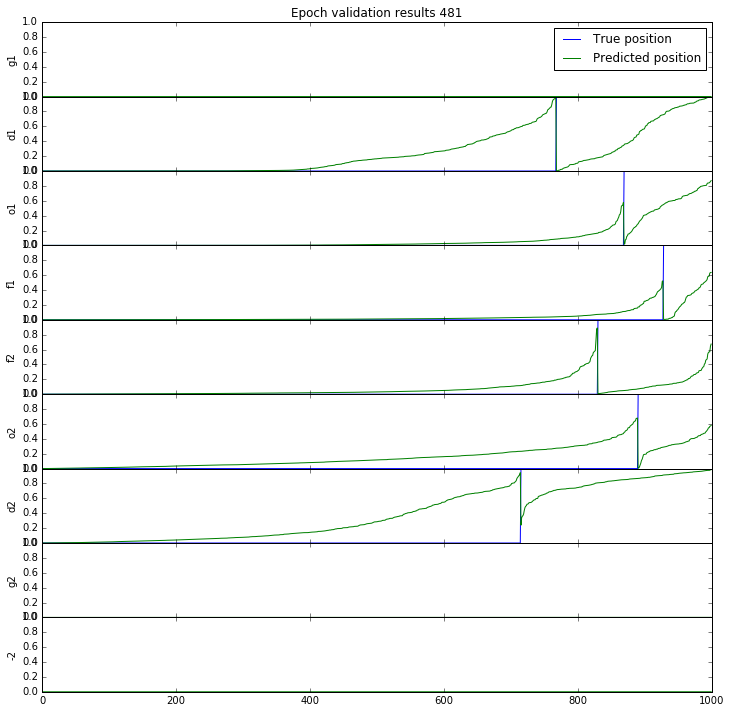

Wrote model to .\ModelsTransfer\weights_481.hdf
Epoch 482/482
88/87 [==============================] - 68s - loss: 0.6836 - categorical_accuracy: 0.7564 - val_loss: 1.0381 - val_categorical_accuracy: 0.6218
Wrote model to .\ModelsTransfer\weights_482.hdf
Epoch 483/483
88/87 [==============================] - 67s - loss: 0.6868 - categorical_accuracy: 0.7451 - val_loss: 1.0673 - val_categorical_accuracy: 0.5769
Wrote model to .\ModelsTransfer\weights_483.hdf
Epoch 484/484
88/87 [==============================] - 68s - loss: 0.7011 - categorical_accuracy: 0.7458 - val_loss: 0.9982 - val_categorical_accuracy: 0.6103
Wrote model to .\ModelsTransfer\weights_484.hdf
Epoch 485/485
88/87 [==============================] - 67s - loss: 0.6842 - categorical_accuracy: 0.7515 - val_loss: 1.0577 - val_categorical_accuracy: 0.6244
Wrote model to .\ModelsTransfer\weights_485.hdf
Epoch 486/486
88/87 [==============================] - 68s - loss: 0.6585 - categorical_accuracy: 0.7610 - val_loss: 1.0165 

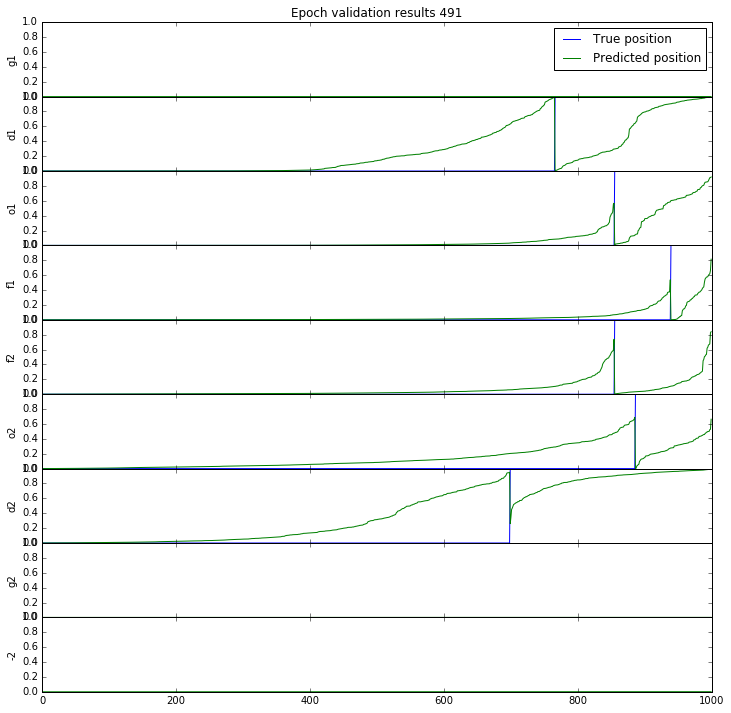

Wrote model to .\ModelsTransfer\weights_491.hdf
Epoch 492/492
88/87 [==============================] - 68s - loss: 0.6491 - categorical_accuracy: 0.7633 - val_loss: 1.0421 - val_categorical_accuracy: 0.5808
Wrote model to .\ModelsTransfer\weights_492.hdf
Epoch 493/493
88/87 [==============================] - 67s - loss: 0.6572 - categorical_accuracy: 0.7553 - val_loss: 1.0512 - val_categorical_accuracy: 0.5821
Wrote model to .\ModelsTransfer\weights_493.hdf
Epoch 494/494
88/87 [==============================] - 68s - loss: 0.6908 - categorical_accuracy: 0.7527 - val_loss: 1.1141 - val_categorical_accuracy: 0.5897
Wrote model to .\ModelsTransfer\weights_494.hdf
Epoch 495/495
88/87 [==============================] - 67s - loss: 0.6860 - categorical_accuracy: 0.7564 - val_loss: 1.0500 - val_categorical_accuracy: 0.5731
Wrote model to .\ModelsTransfer\weights_495.hdf
Epoch 496/496
88/87 [==============================] - 67s - loss: 0.6775 - categorical_accuracy: 0.7473 - val_loss: 1.0875 

In [26]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 100
batches_validation_per_epoch = int(validation.length / batch_size) / 15
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\ModelsTransfer\\weights_%i.hdf'
MODELS_FNAME = '.\\ModelsTransfer\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



Batch size 30: 1279 training batches, 319 validation batches
Epoch 144/144
1280/1279 [==============================] - 603s - loss: 0.6053 - categorical_accuracy: 0.7963 - val_loss: 0.1198 - val_categorical_accuracy: 0.9625


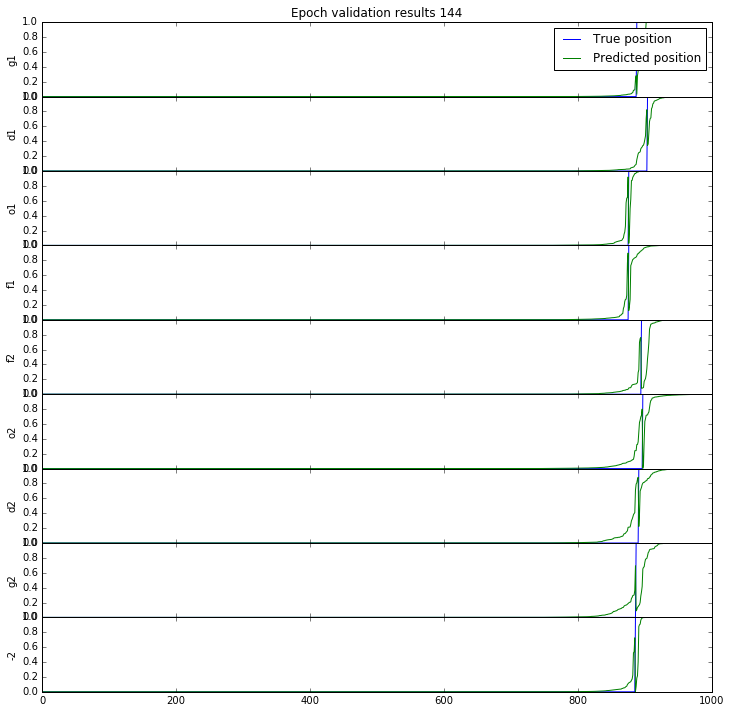

Wrote model to .\Models\weights_144.hdf
Epoch 145/145
1280/1279 [==============================] - 600s - loss: 0.6015 - categorical_accuracy: 0.8003 - val_loss: 0.1255 - val_categorical_accuracy: 0.9602
Wrote model to .\Models\weights_145.hdf
Epoch 146/146
1280/1279 [==============================] - 598s - loss: 0.6038 - categorical_accuracy: 0.7989 - val_loss: 0.1206 - val_categorical_accuracy: 0.9617
Wrote model to .\Models\weights_146.hdf
Epoch 147/147
1280/1279 [==============================] - 598s - loss: 0.6027 - categorical_accuracy: 0.7990 - val_loss: 0.1259 - val_categorical_accuracy: 0.9598
Wrote model to .\Models\weights_147.hdf
Epoch 148/148
1280/1279 [==============================] - 601s - loss: 0.5982 - categorical_accuracy: 0.8006 - val_loss: 0.1226 - val_categorical_accuracy: 0.9611
Wrote model to .\Models\weights_148.hdf
Epoch 149/149
1280/1279 [==============================] - 598s - loss: 0.5998 - categorical_accuracy: 0.8011 - val_loss: 0.1131 - val_categoric

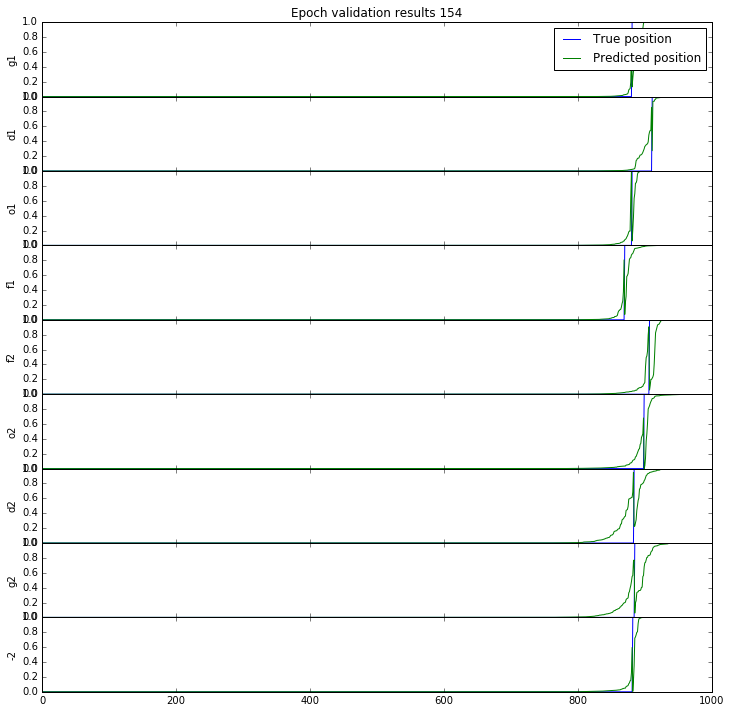

Wrote model to .\Models\weights_154.hdf
Epoch 155/155
1280/1279 [==============================] - 596s - loss: 0.5922 - categorical_accuracy: 0.8030 - val_loss: 0.1241 - val_categorical_accuracy: 0.9581
Wrote model to .\Models\weights_155.hdf
Epoch 156/156
1280/1279 [==============================] - 602s - loss: 0.6021 - categorical_accuracy: 0.7988 - val_loss: 0.1144 - val_categorical_accuracy: 0.9614
Wrote model to .\Models\weights_156.hdf
Epoch 157/157
1280/1279 [==============================] - 597s - loss: 0.5914 - categorical_accuracy: 0.8020 - val_loss: 0.1072 - val_categorical_accuracy: 0.9636
Wrote model to .\Models\weights_157.hdf
Epoch 158/158
1280/1279 [==============================] - 601s - loss: 0.5934 - categorical_accuracy: 0.8020 - val_loss: 0.1132 - val_categorical_accuracy: 0.9635
Wrote model to .\Models\weights_158.hdf
Epoch 159/159
1280/1279 [==============================] - 601s - loss: 0.5896 - categorical_accuracy: 0.8033 - val_loss: 0.1225 - val_categoric

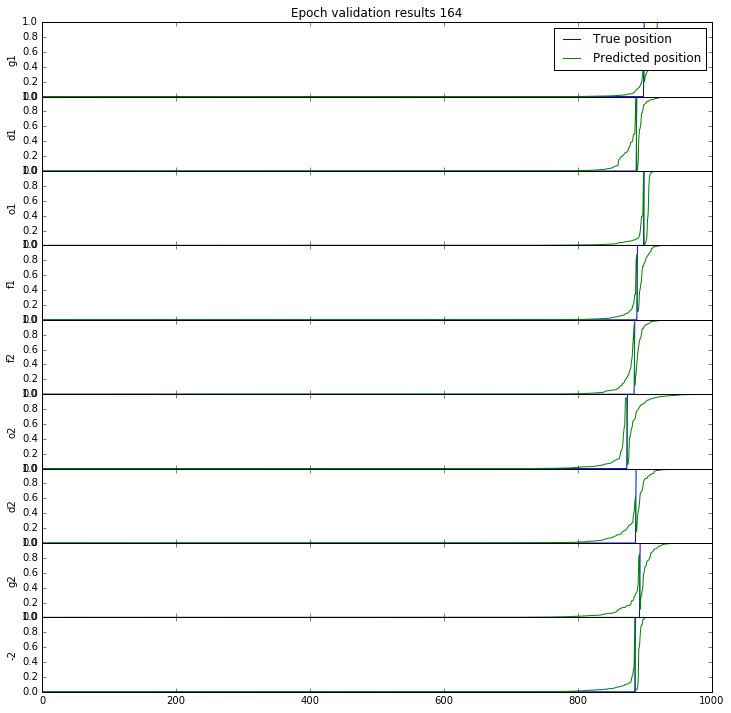

Wrote model to .\Models\weights_164.hdf
Epoch 165/165
1280/1279 [==============================] - 599s - loss: 0.5912 - categorical_accuracy: 0.8017 - val_loss: 0.1081 - val_categorical_accuracy: 0.9656
Wrote model to .\Models\weights_165.hdf
Epoch 166/166
1280/1279 [==============================] - 600s - loss: 0.5906 - categorical_accuracy: 0.8041 - val_loss: 0.1059 - val_categorical_accuracy: 0.9678
Wrote model to .\Models\weights_166.hdf
Epoch 167/167
1280/1279 [==============================] - 600s - loss: 0.5981 - categorical_accuracy: 0.8004 - val_loss: 0.1076 - val_categorical_accuracy: 0.9623
Wrote model to .\Models\weights_167.hdf
Epoch 168/168
1280/1279 [==============================] - 598s - loss: 0.5925 - categorical_accuracy: 0.8025 - val_loss: 0.1089 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_168.hdf
Epoch 169/169
1280/1279 [==============================] - 597s - loss: 0.5942 - categorical_accuracy: 0.8040 - val_loss: 0.1107 - val_categoric

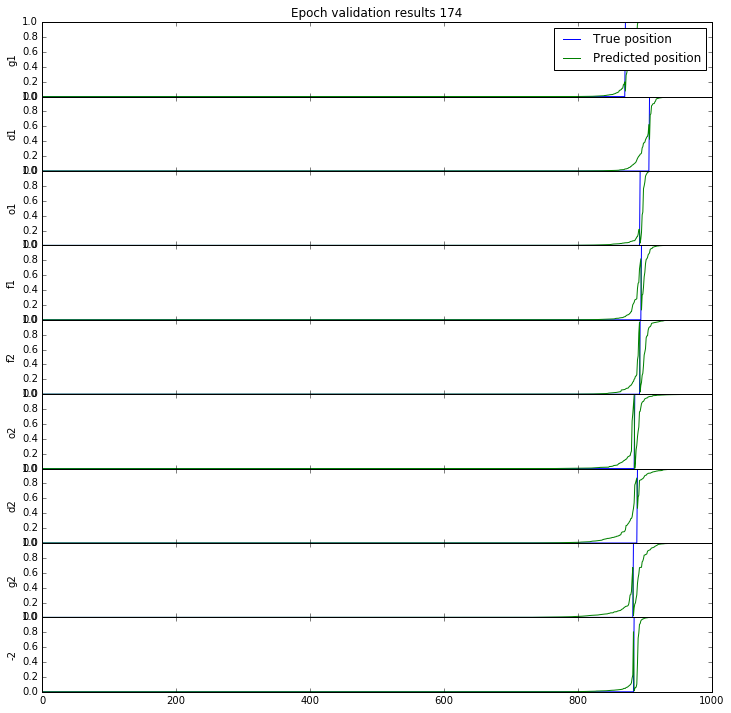

Wrote model to .\Models\weights_174.hdf
Epoch 175/175
1280/1279 [==============================] - 595s - loss: 0.5833 - categorical_accuracy: 0.8046 - val_loss: 0.1151 - val_categorical_accuracy: 0.9653
Wrote model to .\Models\weights_175.hdf
Epoch 176/176
1280/1279 [==============================] - 596s - loss: 0.5800 - categorical_accuracy: 0.8098 - val_loss: 0.1092 - val_categorical_accuracy: 0.9655
Wrote model to .\Models\weights_176.hdf
Epoch 177/177
1280/1279 [==============================] - 597s - loss: 0.5856 - categorical_accuracy: 0.8058 - val_loss: 0.1138 - val_categorical_accuracy: 0.9658
Wrote model to .\Models\weights_177.hdf
Epoch 178/178
1280/1279 [==============================] - 597s - loss: 0.5937 - categorical_accuracy: 0.8053 - val_loss: 0.1146 - val_categorical_accuracy: 0.9632
Wrote model to .\Models\weights_178.hdf
Epoch 179/179
1280/1279 [==============================] - 595s - loss: 0.5827 - categorical_accuracy: 0.8089 - val_loss: 0.1131 - val_categoric

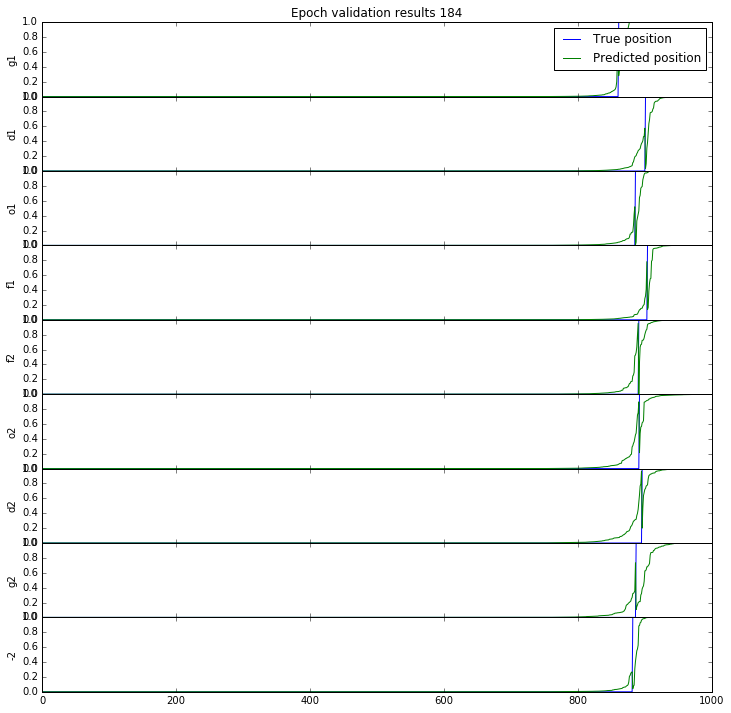

Wrote model to .\Models\weights_184.hdf
Epoch 185/185
1280/1279 [==============================] - 602s - loss: 0.5790 - categorical_accuracy: 0.8079 - val_loss: 0.1147 - val_categorical_accuracy: 0.9673
Wrote model to .\Models\weights_185.hdf
Epoch 186/186
1280/1279 [==============================] - 597s - loss: 0.5767 - categorical_accuracy: 0.8090 - val_loss: 0.1059 - val_categorical_accuracy: 0.9683
Wrote model to .\Models\weights_186.hdf
Epoch 187/187
1280/1279 [==============================] - 599s - loss: 0.5862 - categorical_accuracy: 0.8068 - val_loss: 0.1089 - val_categorical_accuracy: 0.9659
Wrote model to .\Models\weights_187.hdf
Epoch 188/188
1280/1279 [==============================] - 601s - loss: 0.5852 - categorical_accuracy: 0.8079 - val_loss: 0.1118 - val_categorical_accuracy: 0.9634
Wrote model to .\Models\weights_188.hdf
Epoch 189/189
1280/1279 [==============================] - 603s - loss: 0.5810 - categorical_accuracy: 0.8061 - val_loss: 0.1110 - val_categoric

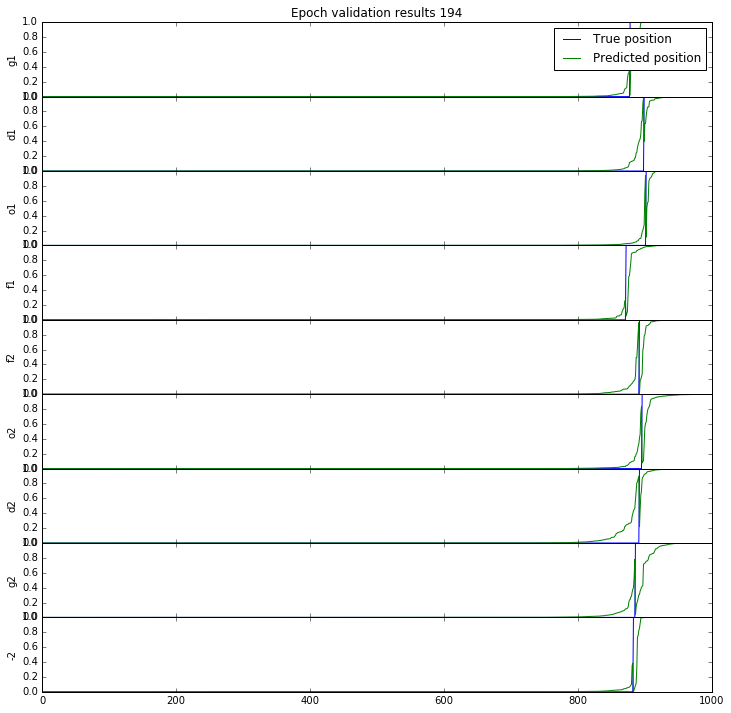

Wrote model to .\Models\weights_194.hdf
Epoch 195/195
1280/1279 [==============================] - 599s - loss: 0.5810 - categorical_accuracy: 0.8074 - val_loss: 0.1052 - val_categorical_accuracy: 0.9649
Wrote model to .\Models\weights_195.hdf
Epoch 196/196
1280/1279 [==============================] - 598s - loss: 0.5752 - categorical_accuracy: 0.8096 - val_loss: 0.1179 - val_categorical_accuracy: 0.9645
Wrote model to .\Models\weights_196.hdf
Epoch 197/197
1280/1279 [==============================] - 598s - loss: 0.5890 - categorical_accuracy: 0.8072 - val_loss: 0.1070 - val_categorical_accuracy: 0.9686
Wrote model to .\Models\weights_197.hdf
Epoch 198/198
1280/1279 [==============================] - 603s - loss: 0.5834 - categorical_accuracy: 0.8071 - val_loss: 0.1213 - val_categorical_accuracy: 0.9639
Wrote model to .\Models\weights_198.hdf
Epoch 199/199
1280/1279 [==============================] - 601s - loss: 0.5693 - categorical_accuracy: 0.8135 - val_loss: 0.1070 - val_categoric

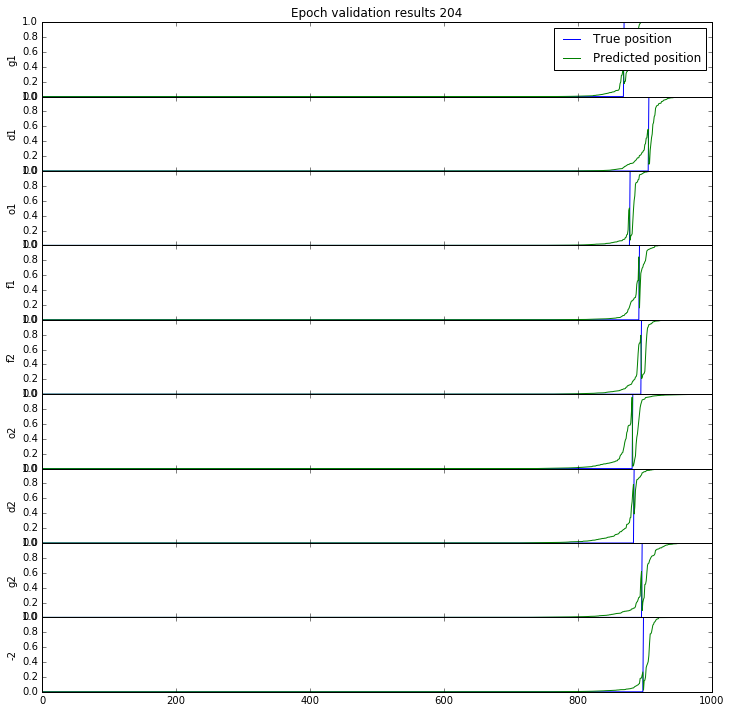

Wrote model to .\Models\weights_204.hdf
Epoch 205/205
1280/1279 [==============================] - 597s - loss: 0.5704 - categorical_accuracy: 0.8115 - val_loss: 0.1085 - val_categorical_accuracy: 0.9668
Wrote model to .\Models\weights_205.hdf
Epoch 206/206
1280/1279 [==============================] - 598s - loss: 0.5759 - categorical_accuracy: 0.8102 - val_loss: 0.1049 - val_categorical_accuracy: 0.9670
Wrote model to .\Models\weights_206.hdf
Epoch 207/207
1280/1279 [==============================] - 599s - loss: 0.5714 - categorical_accuracy: 0.8130 - val_loss: 0.1083 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_207.hdf
Epoch 208/208
 562/1279 [============>.................] - ETA: 312s - loss: 0.5738 - categorical_accuracy: 0.8079

KeyboardInterrupt: 

In [9]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 143
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)

